# Synthetic financial time series generation with regime clustering. CLFF, CLGAN and CLSGAN
### Kirill Zakharov
### Supervisor: Elizaveta Stavinova
ITMO University, 2023

In [1]:
# Requirements
# !pip install ruptures
# !pip install stumpy
# !pip install scipy
# !pip install sklearn
# !pip install torch torchvision
# !pip install yfinance
# !pip install pyts
# !pip install statsmodels
# !pip install fbprophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import scipy.stats as sts
from scipy import signal
import copy
import pickle

import yfinance as yf

import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyts.decomposition import SingularSpectrumAnalysis

from tools.WLambert_Transform import *
from tools.data_preprocessing import *
from tools.time_series_clustering import *
from tools.operators import *

import models.TCBGAN as gan
import models.Clustering_GAN as ssagan
import models.Approximator as approx
import models.NormalizationFlows as flows
import models.torch_tcn as tcn
from models.GAN_models import *

from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp
from scipy.signal import argrelextrema
from statsmodels.tsa.seasonal import seasonal_decompose

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.style.use('ggplot')

# Data Import

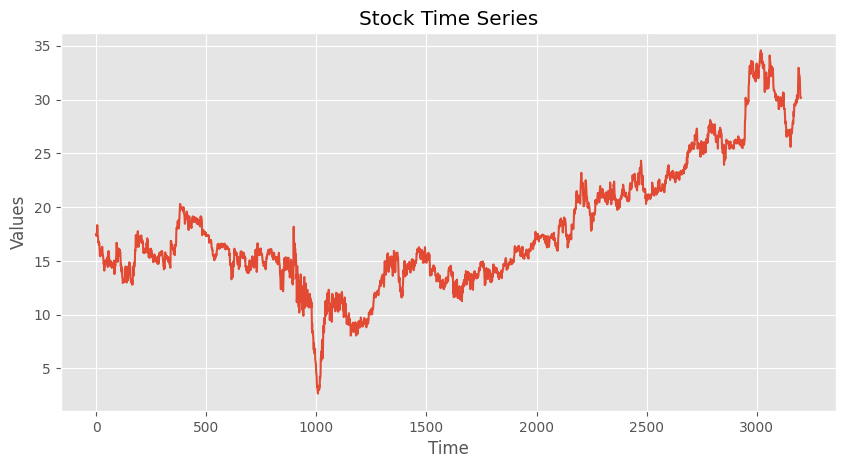

In [3]:
plt.subplots(figsize=(10,5), dpi=100)

name = 'fisi'
data = pd.read_csv(f'Data/Stocks/{name}.us.txt')
# data = pd.read_csv(f'Data/ETFs/{name}.us.txt')

# data = yf.download('AAPL','2013-05-01','2019-12-31')
data = data.iloc[:,1:-2].astype(float)

plt.plot(data.Close)

plt.title('Stock Time Series')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

In [4]:
len(data)

3200

# Regime Clustering

In [5]:
num_clusters = 3
kernel = 'l2'
jump = 1
min_size = 2**7
penalty = 1

In [6]:
ts_wind, length, index_array, idx_cp, splitted, delta_array = split_ts_clustering(data.Close.values, num_clusters,
                                                   kernel, jump, min_size, penalty)

In [7]:
init_values = list(map(lambda x: x[0], ts_wind)) #initial values at each cluster for reconstruction
init_values

[17.472, 17.479, 26.027]

In [8]:
index_array #indecies of regimes in clusters

[array([ 3,  5,  6,  8, 10, 11, 13, 17]),
 array([ 0,  1,  2,  4,  7,  9, 12, 14, 15, 16, 18, 21]),
 array([19, 20])]

### Visualisation of clusters

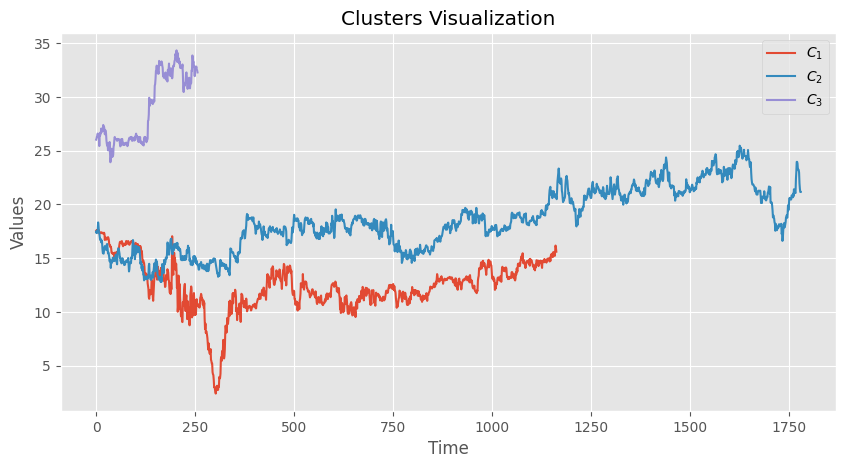

In [9]:
plt.subplots(figsize=(10,5), dpi=100)

for i in range(len(ts_wind)):
    plt.plot(ts_wind[i], label=f'$C_{i+1}$')

plt.title('Clusters Visualization')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

plt.savefig(f'Clusters_{name}.jpg', dpi=120)
plt.show()

In [10]:
delta_array #reconstruction deltas

[[-1.1310000000000002,
  -0.2509990000000002,
  -1.4649979999999996,
  -1.7229970000000012,
  -2.353996000000002,
  -4.186995000000005,
  -8.435994000000004],
 [-0.9390000000000001,
  -1.1749990000000015,
  2.9060019999999973,
  6.509003,
  3.4070040000000024,
  2.8630050000000047,
  0.15300600000000486,
  0.2340070000000054,
  0.06000800000000339,
  -2.630990999999998,
  -8.988989999999998],
 [-0.24399999999999977]]

# Methods 

## QuantGAN without clustering

In [11]:
log_return_processed_QGAN, log_returns_QGAN, standardScaler1, standardScaler2, gaussianize = quantgan_preprocessing(data.Close)

In [12]:
generator_QGAN, scores_quantgan = quantgan_fit(log_return_processed_QGAN, num_epochs=20, \
                              seq_len=127, batch_size=80, z_dim=2, train=True)

Discriminator Loss: -1.3912439 || Generator Loss: -0.62514: 100%|██████████| 20/20 [14:31<00:00, 43.57s/it]


### Generate Synthetics

In [13]:
num_synths = 40
seeds = np.random.randint(12345, 1e6, size=num_synths) #generate list of seeds

In [14]:
z_dim = 2
load = False
synths_quantgan = []
for i in range(num_synths):
    seed = seeds[i]
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) #fix seed for appropriate comparison
    
    if load:
        model = tcn.Generator()
        model.load_state_dict(torch.load(f'QuantGAN_{name}.pkl'))
        model.eval()

        result_QuantGAN = quantGAN_generate_synth(model, log_returns_QGAN, data.Close.values,\
                                                  standardScaler1, standardScaler2, gaussianize, z_dim)
        synths_quantgan.append(result_QuantGAN)
    else:
        torch.save(generator_QGAN.state_dict(), f'QuantGAN_{name}.pkl')

        result_QuantGAN = quantGAN_generate_synth(generator_QGAN, log_returns_QGAN, data.Close.values,\
                                                  standardScaler1, standardScaler2, gaussianize, z_dim)
        synths_quantgan.append(result_QuantGAN)

In [15]:
result_QuantGAN = []
for i in range(num_synths):
    result_QuantGAN.append(data.Close.values[0] * np.exp(synths_quantgan[i].cumsum()))

In [16]:
result_QuantGAN = np.array(result_QuantGAN)[~(np.max(result_QuantGAN, axis=1) > 1.3*np.max(data.Close.values))]

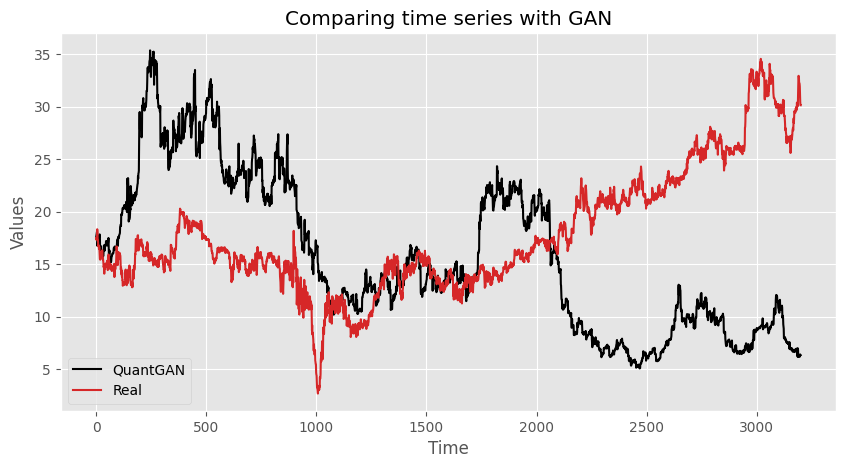

In [17]:
plt.subplots(figsize=(10,5), dpi=100)

plt.plot(result_QuantGAN[0], alpha=1, color='black', label='QuantGAN')    
plt.plot(data.Close.values[:], label='Real', color='tab:red')


plt.title('Comparing time series with GAN')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

### Loss functions

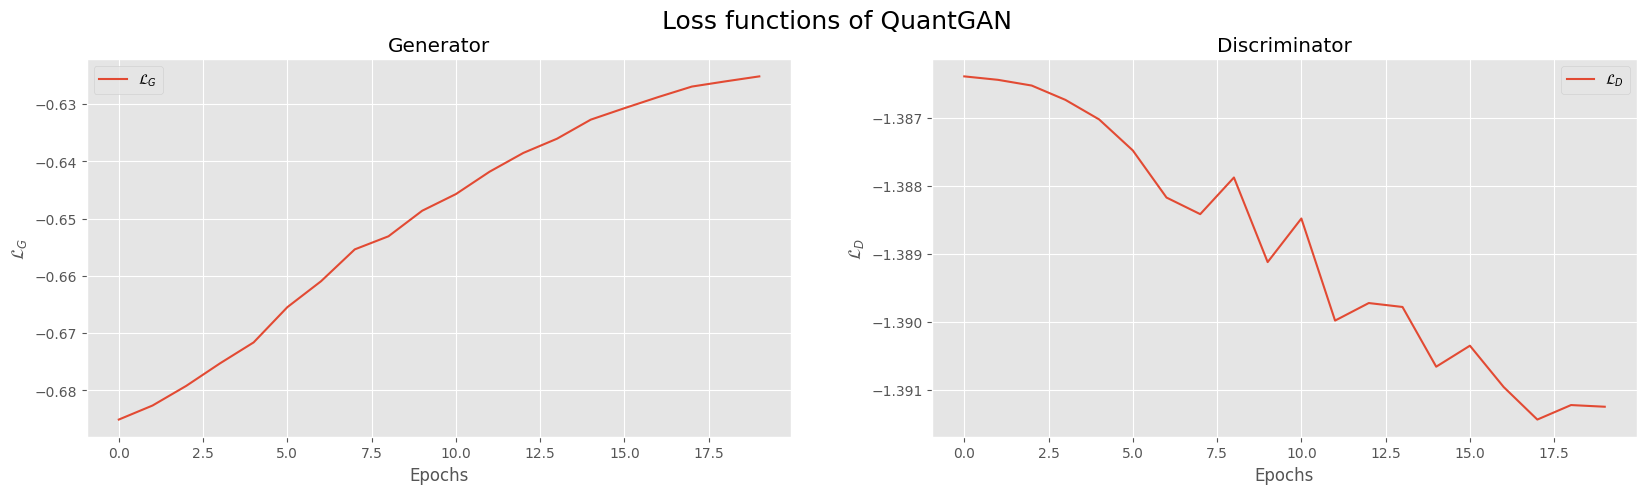

In [18]:
figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5), dpi=100)

axs[0].plot(scores_quantgan[0], label='$\mathcal{L}_G$')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('$\mathcal{L}_G$')
axs[0].set_title('Generator')

axs[1].plot(scores_quantgan[1], label='$\mathcal{L}_D$')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('$\mathcal{L}_D$')
axs[1].set_title('Discriminator')

figure.suptitle('Loss functions of QuantGAN', fontsize=18)
plt.show()

#### Dynamically change number of epochs with respect to the length of cluster

In [19]:
lin_space_epochs = np.linspace(25, 6, 23).astype(int)

In [20]:
zipped_len_epochs = list(zip(np.array([(len(data) // 23)*i for i in range(23)]), lin_space_epochs))

In [21]:
zipped_len_epochs

[(0, 25),
 (139, 24),
 (278, 23),
 (417, 22),
 (556, 21),
 (695, 20),
 (834, 19),
 (973, 18),
 (1112, 18),
 (1251, 17),
 (1390, 16),
 (1529, 15),
 (1668, 14),
 (1807, 13),
 (1946, 12),
 (2085, 12),
 (2224, 11),
 (2363, 10),
 (2502, 9),
 (2641, 8),
 (2780, 7),
 (2919, 6),
 (3058, 6)]

## CLGAN

In [22]:
epochs = 15
seq_len = 127
batch_size = 80
n_fclayers = 3
feature_dim = 1
z_dim = 3
H = 7

In [23]:
generators_cluster = []
processed_params_cluster = []
scores_clgan = []
for j in range(num_clusters):
    for i in range(1, len(zipped_len_epochs)):
            if len(ts_wind[j]) <= zipped_len_epochs[i][0]:
                epochs = zipped_len_epochs[i-1][1]
                break
    
    print(f'-------------------\nStart training g_{j}\n-------------------')
    
    if len(ts_wind[j]) < H*seq_len:
        num_ssa = int(np.ceil(H * seq_len / len(ts_wind[j])))
        
        generators, log_returns, standardScaler1, standardScaler2, gaussianize, score = \
                                    ssagan.QuantGAN_SSA_training(ts_wind[j], epochs, seq_len,\
                                    batch_size, n_fclayers, feature_dim, z_dim, wsize=2**6,\
                                    groups=num_ssa, logreturn=True, lambert=True, decomposition=True)

        processed_params = log_returns, standardScaler1, standardScaler2, gaussianize
        generators_cluster.append(generators)
        processed_params_cluster.append(processed_params)
        scores_clgan.append(score)
        
    else:
        generators, log_returns, standardScaler1, standardScaler2, gaussianize, score = ssagan.QuantGAN_SSA_training(ts_wind[j], epochs, seq_len, batch_size,
                    n_fclayers, feature_dim, z_dim, wsize=2**6, groups=2, logreturn=True, lambert=True, decomposition=False)
        
        processed_params = log_returns, standardScaler1, standardScaler2, gaussianize
        generators_cluster.append(generators)
        processed_params_cluster.append(processed_params)
        scores_clgan.append(score)

  0%|          | 0/18 [00:00<?, ?it/s]

-------------------
Start training g_0
-------------------


Discriminator Loss: -1.3870347 || Generator Loss: -0.67398: 100%|██████████| 18/18 [04:28<00:00, 14.93s/it]
  0%|          | 0/14 [00:00<?, ?it/s]

-------------------
Start training g_1
-------------------


Discriminator Loss: -1.3876125 || Generator Loss: -0.72825: 100%|██████████| 14/14 [05:31<00:00, 23.66s/it]
  0%|          | 0/24 [00:00<?, ?it/s]

-------------------
Start training g_2
-------------------


Discriminator Loss: -1.3870792 || Generator Loss: -0.72448: 100%|██████████| 24/24 [06:31<00:00, 16.33s/it]


### Generate synthetics

In [24]:
def generate_synths_CLGAN(generators, num_synth, data, processed_params, z_dim, num_clusters,\
                    init_values, length, index_array, idx_cp, splitted_real, ts_wind):
    synths = []

    for i in range(num_synth):
        seed = seeds[i]
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        
        F_tilde_cluster = []

        for j in range(num_clusters):
            if len(ts_wind[j]) < H * seq_len:
                
                if isinstance(generators[j], list):
                    F_tilde = ssagan.QuantGAN_generate_synth(ts_wind[j], list(map(lambda x: x.eval(), generators[j])), processed_params[j],\
                                                    z_dim, decomposition=True)

                    F_tilde_cluster.append(F_tilde)
                else:
                    F_tilde = ssagan.QuantGAN_generate_synth(ts_wind[j], list(map(lambda x: x.eval(), [generators[j]])), processed_params[j],\
                                                    z_dim, decomposition=True)

                    F_tilde_cluster.append(F_tilde)

            else: 
                F_tilde = ssagan.QuantGAN_generate_synth(ts_wind[j], list(map(lambda x: x.eval(), [generators[j]]))[0], processed_params[j],\
                                                z_dim, decomposition=False)

                F_tilde_cluster.append(F_tilde)
        
        F_tilde_reconstruct = []
        for j in range(num_clusters):
            if isinstance(F_tilde_cluster[j], list):
                F_tilde_reconstruct.append(np.exp(F_tilde_cluster[j][0].cumsum()) * init_values[j])
            else:
                F_tilde_reconstruct.append(np.exp(F_tilde_cluster[j].cumsum()) * init_values[j])
            
        result = ts_reconstruction(F_tilde_reconstruct, data, length, num_clusters, index_array, delta_array)
        
        result = approx.regime_smoothing(result, data, idx_cp, splitted_real, beta=0.05,\
                                         win_size=100, smooth_trend=False)
         
        synths.append(result)
        
    return synths, F_tilde_reconstruct

In [25]:
load = False #if you have saved models and params choose "True"
num_synths = 40 #number of synthetic time series

# seed = 20222022
# np.random.seed(seed)
# random.seed(seed)
# torch.manual_seed(seed)


if load:
    models = []
    processed_params_load = []
    
    for i in range(num_clusters):
        #load generators
        model = tcn.Generator()
        model.load_state_dict(torch.load(f'gcl_{name}_{i}.pkl'))
        model.eval()
        models.append(model)
        
        #load processed params
        with open(f'processed_params_{name}_{i}.pkl','rb') as f:
            x = pickle.load(f)

        processed_params_load.append(x)
        
    result_CLGAN, F_tilde, ft = generate_synths_CLGAN(models, num_synths, data.Close.values, processed_params_cluster, z_dim, num_clusters,\
                    init_values, length, index_array, idx_cp, splitted, ts_wind)
else:
    
    for i in range(num_clusters):
        if isinstance(generators_cluster[i], list):
            torch.save(generators_cluster[i][0].state_dict(), f'gcl_{name}_{i}.pkl')
        else:
            torch.save(generators_cluster[i].state_dict(), f'gcl_{name}_{i}.pkl')

    for i in range(num_clusters):
        with open(f'processed_params_{name}_{i}.pkl','wb') as f:
            pickle.dump(processed_params_cluster[i], f)
    
    # generators_cluster = list(map(lambda x: x[0].eval(), generators_cluster))
    result_CLGAN, F_tilde = generate_synths_CLGAN(generators_cluster, num_synths, data.Close.values, processed_params_cluster, z_dim, num_clusters,\
                    init_values, length, index_array, idx_cp, splitted, ts_wind)

In [26]:
result_CLGAN = np.array(result_CLGAN)[(~(np.max(result_CLGAN, axis=1) > 1.3*np.max(data.Close.values))) & (~(np.min(result_CLGAN, axis=1) < 0))]

In [27]:
# test = approx.regime_smoothing(result_CLGAN[1], data.Close.values, idx_cp, splitted, beta=0.01,\
#                                          win_size=100, smooth_trend=False)

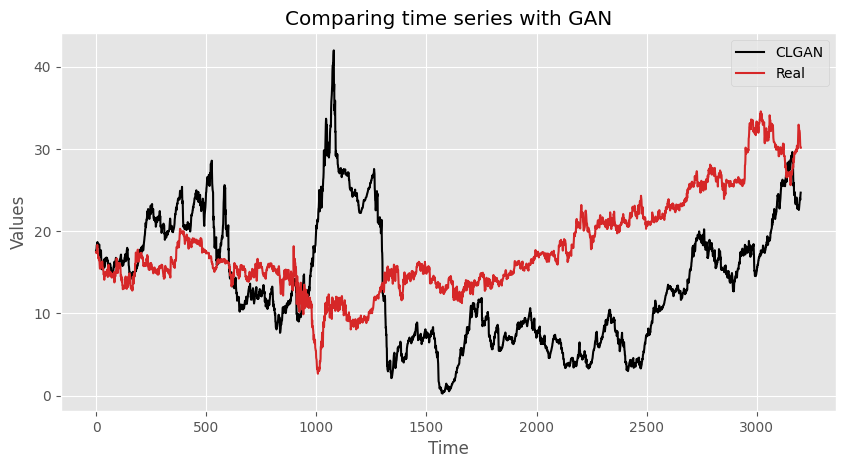

In [28]:
plt.subplots(figsize=(10,5), dpi=100)

plt.plot(result_CLGAN[0], alpha=1, color='black', label='CLGAN')    
plt.plot(data.Close.values[:], label='Real', color='tab:red')
# plt.plot(test, color='green')

plt.title('Comparing time series with GAN')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

### Loss functions

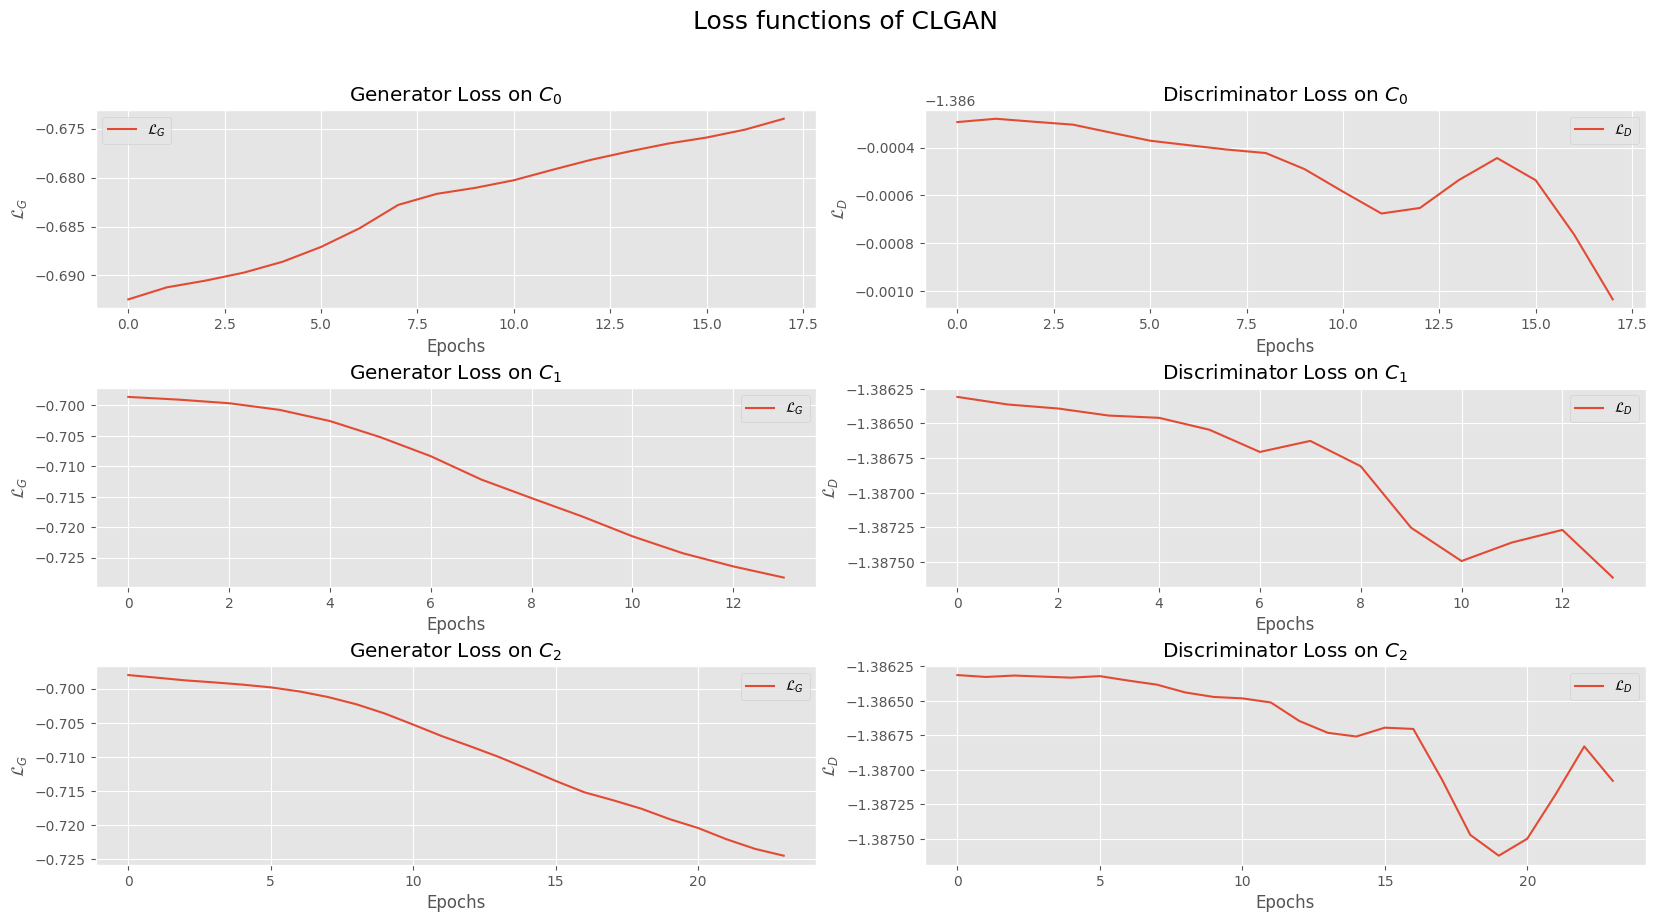

In [29]:
figure, axs = plt.subplots(nrows=num_clusters, ncols=2, figsize=(20,10), dpi=100)

for i in range(num_clusters):
    axs[i,0].plot(scores_clgan[i][0], label='$\mathcal{L}_G$')
    axs[i,0].legend()
    axs[i,0].set_xlabel('Epochs')
    axs[i,0].set_ylabel('$\mathcal{L}_G$')
    axs[i,0].set_title(f'Generator Loss on $C_{i}$')

    axs[i,1].plot(scores_clgan[i][1], label='$\mathcal{L}_D$')
    axs[i,1].legend()
    axs[i,1].set_xlabel('Epochs')
    axs[i,1].set_ylabel('$\mathcal{L}_D$')
    axs[i,1].set_title(f'Discriminator Loss on $C_{i}$')

figure.suptitle('Loss functions of CLGAN', fontsize=18)
plt.subplots_adjust(wspace=0.15, hspace=0.4)
plt.show()

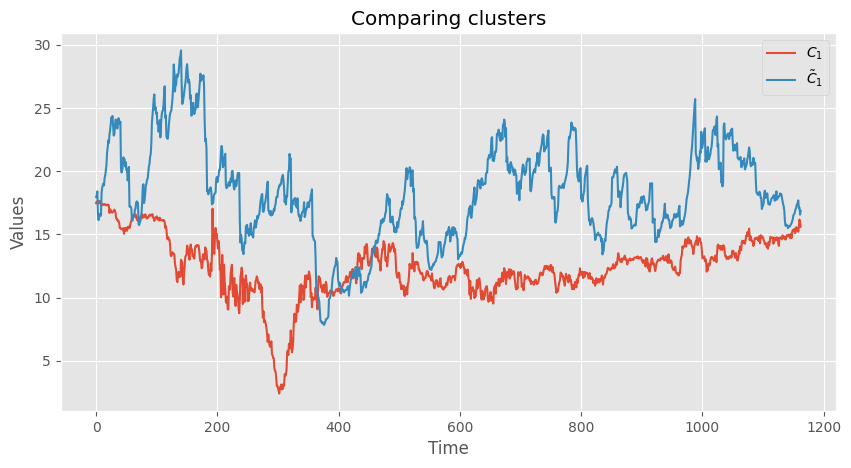

In [30]:
plt.subplots(figsize=(10,5), dpi=100)

i = 0

plt.plot(ts_wind[i], label=f'$C_{i+1}$')
plt.plot(F_tilde[i], label=r'$\tilde{C}_{%.0f}$' % (i+1))

plt.title('Comparing clusters')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

## CLSGAN

In [31]:
epochs = 15
seq_len = 127
batch_size = 80
n_fclayers = 3
feature_dim = 1
z_dim = 3
H = 7

In [32]:
generators_cluster = []
processed_params_cluster = []
supervisors = []
scores_clsgan = []
for j in range(num_clusters):
    for i in range(1, len(zipped_len_epochs)):
            if len(ts_wind[j]) <= zipped_len_epochs[i][0]:
                epochs = zipped_len_epochs[i-1][1]
                break
                
    print(f'-------------------\nStart training g_{j}\n-------------------')
    
    if len(ts_wind[j]) < H*seq_len:
        num_ssa = int(np.ceil(H * seq_len / len(ts_wind[j])))
        generators, supervisor, log_returns, standardScaler1, standardScaler2, gaussianize, m, scores = ssagan.CLSGAN_training(ts_wind[j], epochs, seq_len, batch_size,
                    n_fclayers, feature_dim, z_dim, wsize=2**6, groups=num_ssa, decomposition=True)

        processed_params = log_returns, standardScaler1, standardScaler2, gaussianize, m
        generators_cluster.append(generators)
        supervisors.append(supervisor)
        processed_params_cluster.append(processed_params)
        scores_clsgan.append(scores)
        
    else:
        generators, supervisor, log_returns, standardScaler1, standardScaler2, gaussianize, m, scores = ssagan.CLSGAN_training(ts_wind[j], epochs, seq_len, batch_size,
                    n_fclayers, feature_dim, z_dim, wsize=2**6, groups=2, decomposition=False)
        
        processed_params = log_returns, standardScaler1, standardScaler2, gaussianize, m
        generators_cluster.append(generators)
        supervisors.append(supervisor)
        processed_params_cluster.append(processed_params)
        scores_clsgan.append(scores)

  0%|          | 0/18 [00:00<?, ?it/s]

-------------------
Start training g_0
-------------------


D1 Loss: -1.3863424 || D2 Loss: -1.3863882 || G Loss: -0.69583 || S Loss: -0.48599: 100%|██████████| 18/18 [12:03<00:00, 40.20s/it]
  0%|          | 0/14 [00:00<?, ?it/s]

-------------------
Start training g_1
-------------------


D1 Loss: -1.3873048 || D2 Loss: -1.3876220 || G Loss: -0.72180 || S Loss: -0.45387: 100%|██████████| 14/14 [15:18<00:00, 65.63s/it]
  0%|          | 0/24 [00:00<?, ?it/s]

-------------------
Start training g_2
-------------------


D1 Loss: -1.3865266 || D2 Loss: -1.3875560 || G Loss: -0.67492 || S Loss: -0.18344: 100%|██████████| 24/24 [17:48<00:00, 44.54s/it]


### Generate synthetics

In [33]:
def generate_synths_CLSGAN(generators, supervisors, num_synth, data, processed_params, z_dim, num_clusters,\
                    init_values, length, index_array, idx_cp, splitted_real, ts_wind):
    synths = []

    for i in range(num_synth):
        seed = seeds[i]
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        
        F_tilde_cluster = []

        for j in range(num_clusters):
            if len(ts_wind[j]) < H * seq_len:
                
                if isinstance(generators[j], list):
                    F_tilde = ssagan.CLSGAN_generate_synth(ts_wind[j], list(map(lambda x: x.eval(), generators[j])), list(map(lambda x: x.eval(), supervisors[j])), processed_params[j],\
                                                    z_dim, decomposition=True)

                    F_tilde_cluster.append(F_tilde)
                else:
                    F_tilde = ssagan.CLSGAN_generate_synth(ts_wind[j], list(map(lambda x: x.eval(), [generators[j]])), list(map(lambda x: x.eval(), [supervisors[j]])), processed_params[j],\
                                                    z_dim, decomposition=True)

                    F_tilde_cluster.append(F_tilde)

            else: 
                F_tilde = ssagan.CLSGAN_generate_synth(ts_wind[j], list(map(lambda x: x.eval(), [generators[j]]))[0], list(map(lambda x: x.eval(), [supervisors[j]]))[0], processed_params[j],\
                                                z_dim, decomposition=False)

                F_tilde_cluster.append(F_tilde)
        
        F_tilde_reconstruct = []
        for j in range(num_clusters):
            if isinstance(F_tilde_cluster[j], list):
                F_tilde_reconstruct.append(np.exp(F_tilde_cluster[j][0].cumsum()) * init_values[j])
            else:
                F_tilde_reconstruct.append(np.exp(F_tilde_cluster[j].cumsum()) * init_values[j])
            
        result = ts_reconstruction(F_tilde_reconstruct, data, length, num_clusters, index_array, delta_array)
        
        result = approx.regime_smoothing(result, data, idx_cp, splitted_real, beta=0.01,\
                                         win_size=100, smooth_trend=False)
        synths.append(result)
        
    return synths, F_tilde_reconstruct

In [34]:
load = False #if you have saved models and params choose "True"
num_synths = 40 #number of synthetic time series

# np.random.seed(seed)
# random.seed(seed)
# torch.manual_seed(seed)


if load:
    models = []
    processed_params_load = []
    
    for i in range(num_clusters):
        #load generators
        model = tcn.Generator(z_dim)
        model.load_state_dict(torch.load(f'CLSGAN_{name}_{i}.pkl'))
        model.eval()
        models.append(model)
        
        #load processed params
        with open(f'processed_params_{name}_{i}.pkl','rb') as f:
            x = pickle.load(f)

        processed_params_load.append(x)
        
    result_CLSGAN, F_tilde = generate_synths_CLSGAN(models, supervisors, num_synths, data.Close.values, processed_params_cluster, z_dim, num_clusters,\
                    init_values, length, index_array, idx_cp, splitted, ts_wind)
else:
    
    for i in range(num_clusters):
        if isinstance(generators_cluster[i], list):
            torch.save(generators_cluster[i][0].state_dict(), f'CLSGAN_{name}_{i}.pkl')
        else:
            torch.save(generators_cluster[i].state_dict(), f'CLSGAN_{name}_{i}.pkl')

    for i in range(num_clusters):
        with open(f'processed_params_{name}_{i}.pkl','wb') as f:
            pickle.dump(processed_params_cluster[i], f)
            
    # generators_cluster = list(map(lambda x: x[0].eval(), generators_cluster))
    result_CLSGAN, F_tilde = generate_synths_CLSGAN(generators_cluster, supervisors, num_synths, data.Close.values, processed_params_cluster, z_dim, num_clusters,\
                    init_values, length, index_array, idx_cp, splitted, ts_wind)

In [35]:
result_CLSGAN = np.array(result_CLSGAN)[(~(np.max(result_CLSGAN, axis=1) > 1.3*np.max(data.Close.values))) & (~(np.min(result_CLSGAN, axis=1) < 0))]

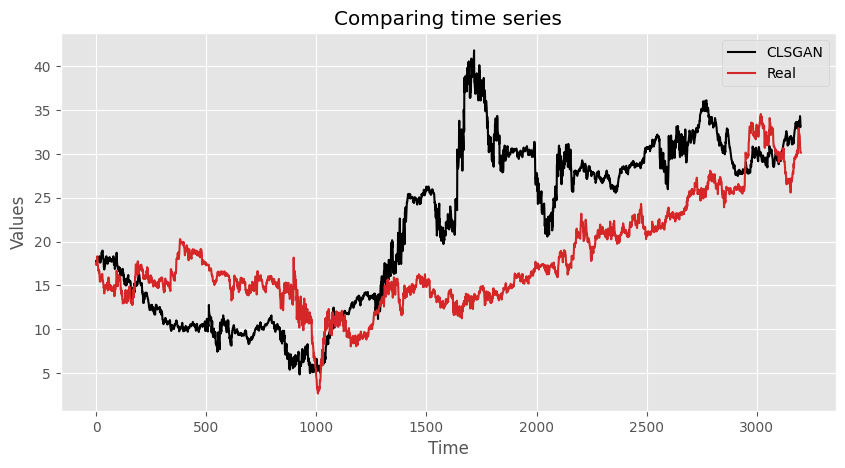

In [41]:
plt.subplots(figsize=(10,5), dpi=100) 

plt.plot(result_CLSGAN[3], label='CLSGAN', color='black')
plt.plot(data.Close.values[:], label='Real', color='tab:red')


plt.title('Comparing time series')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
# plt.savefig(f'Samples_{name}.jpg', dpi=120) #save figure
plt.show()

### Loss functions

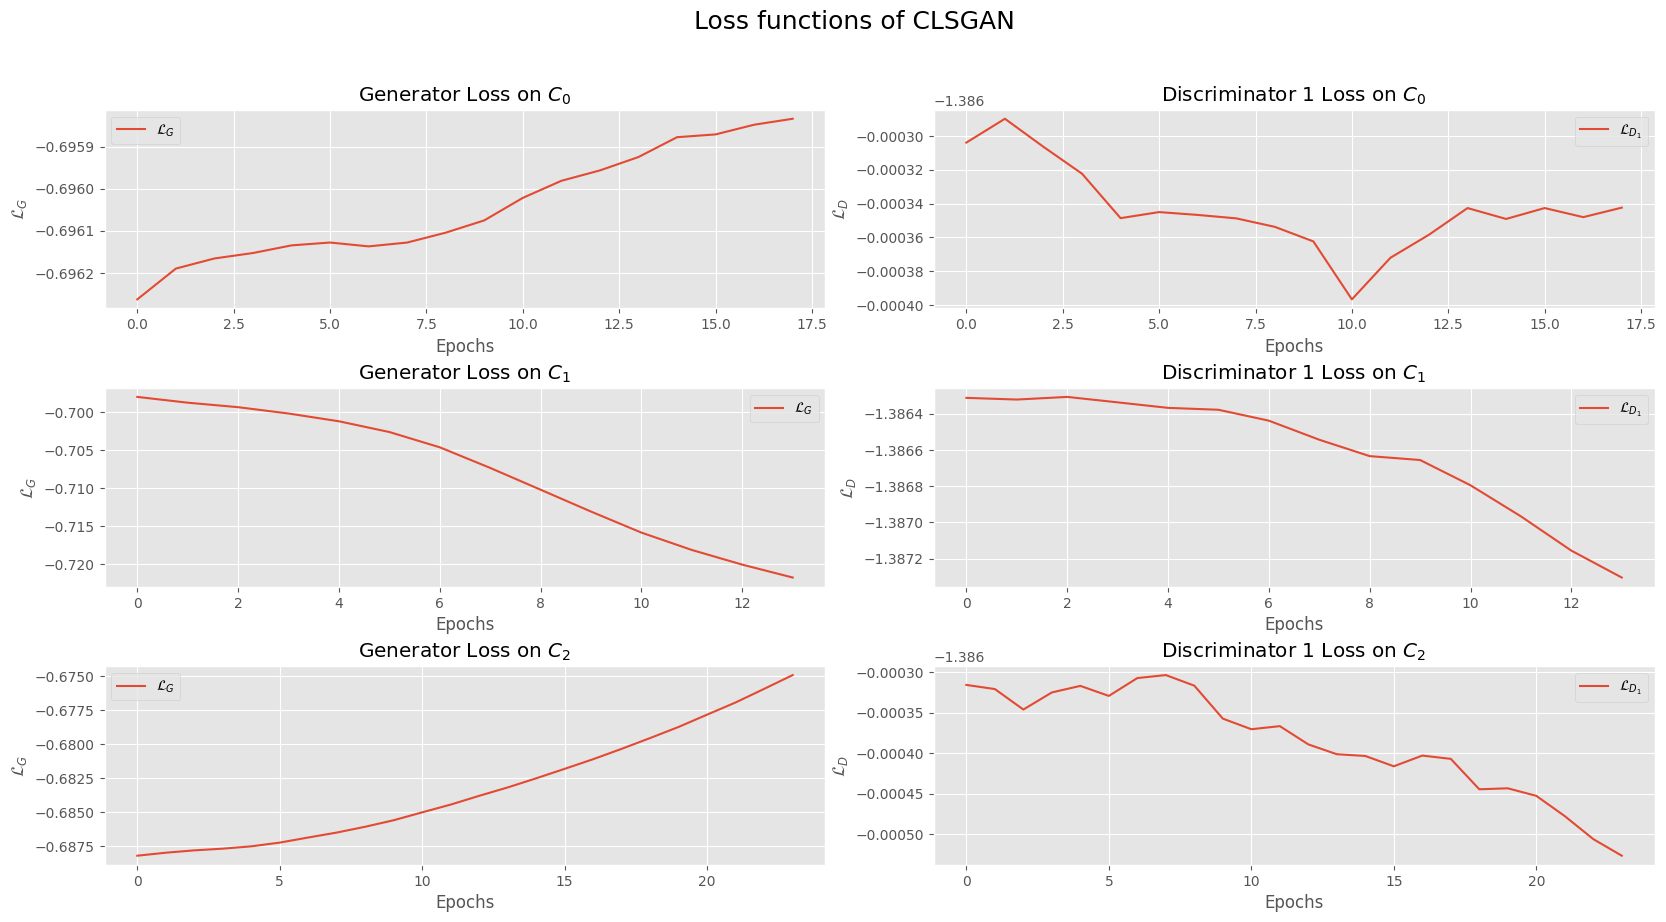

In [37]:
figure, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10), dpi=100)

for i in range(num_clusters):
    axs[i,0].plot(scores_clsgan[i][0], label='$\mathcal{L}_G$')
    axs[i,0].legend()
    axs[i,0].set_xlabel('Epochs')
    axs[i,0].set_ylabel('$\mathcal{L}_G$')
    axs[i,0].set_title(f'Generator Loss on $C_{i}$')

    axs[i,1].plot(scores_clsgan[i][1], label='$\mathcal{L}_{D_1}$')
    axs[i,1].legend()
    axs[i,1].set_xlabel('Epochs')
    axs[i,1].set_ylabel('$\mathcal{L}_D$')
    axs[i,1].set_title(f'Discriminator 1 Loss on $C_{i}$')

figure.suptitle('Loss functions of CLSGAN', fontsize=18)
plt.subplots_adjust(wspace=0.15, hspace=0.4)
plt.show()

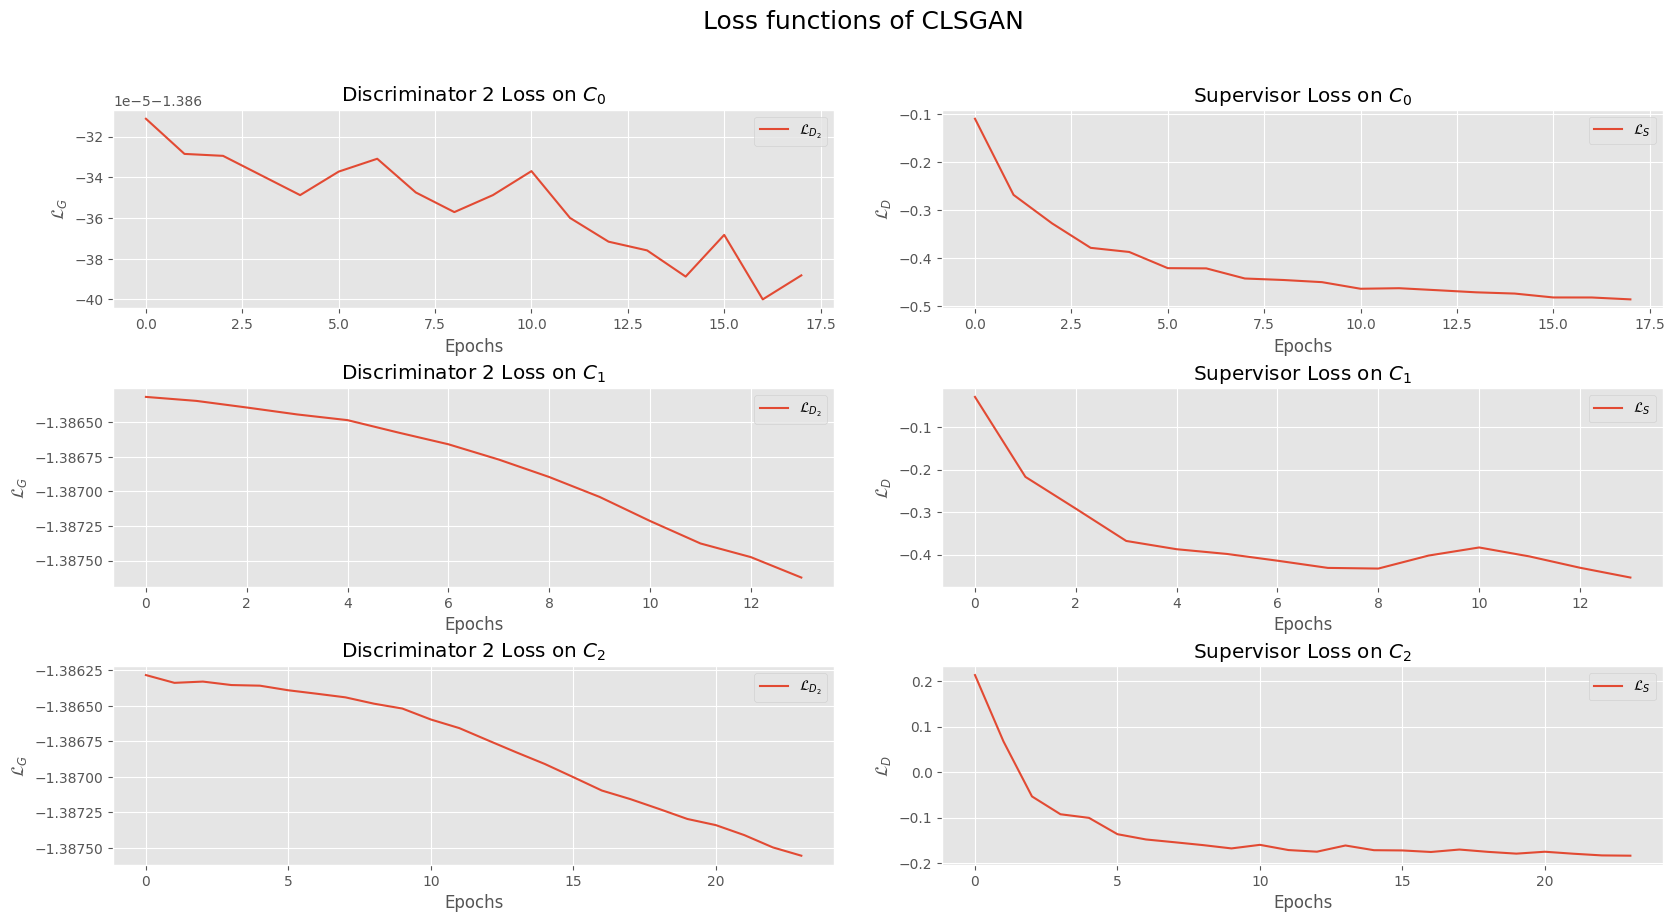

In [38]:
figure, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10), dpi=100)

for i in range(num_clusters):
    axs[i,0].plot(scores_clsgan[i][2], label='$\mathcal{L}_{D_2}$')
    axs[i,0].legend()
    axs[i,0].set_xlabel('Epochs')
    axs[i,0].set_ylabel('$\mathcal{L}_G$')
    axs[i,0].set_title(f'Discriminator 2 Loss on $C_{i}$')

    axs[i,1].plot(scores_clsgan[i][3], label='$\mathcal{L}_S$')
    axs[i,1].legend()
    axs[i,1].set_xlabel('Epochs')
    axs[i,1].set_ylabel('$\mathcal{L}_D$')
    axs[i,1].set_title(f'Supervisor Loss on $C_{i}$')

figure.suptitle('Loss functions of CLSGAN', fontsize=18)
plt.subplots_adjust(wspace=0.15, hspace=0.4)
plt.show()

## CLFF

In [43]:
FF_model = flows.f_fit(num_clusters, ts_wind, epochs=1000, hidden=200, n_flows=10,\
                   display_step=100, lr=1e-4)

Start training Fourier Flows
step: 0 	/ 1000 	----------	loss: 1045.280
step: 100 	/ 1000 	|---------	loss: -4421.066
step: 200 	/ 1000 	||--------	loss: -5831.411
step: 300 	/ 1000 	|||-------	loss: -6443.777
step: 400 	/ 1000 	||||------	loss: -7146.786
step: 500 	/ 1000 	|||||-----	loss: -7505.975
step: 600 	/ 1000 	||||||----	loss: -7476.395
step: 700 	/ 1000 	|||||||---	loss: -7164.686
step: 800 	/ 1000 	||||||||--	loss: -6966.607
step: 900 	/ 1000 	|||||||||-	loss: -7794.510
step: 999 	/ 1000 	||||||||||	loss: -8006.589
Finished training!
Start training Fourier Flows
step: 0 	/ 1000 	----------	loss: 591.338
step: 100 	/ 1000 	|---------	loss: -2685.666
step: 200 	/ 1000 	||--------	loss: -3752.667
step: 300 	/ 1000 	|||-------	loss: -3855.104
step: 400 	/ 1000 	||||------	loss: -4265.203
step: 500 	/ 1000 	|||||-----	loss: -4413.496
step: 600 	/ 1000 	||||||----	loss: -4391.350
step: 700 	/ 1000 	|||||||---	loss: -4311.603
step: 800 	/ 1000 	||||||||--	loss: -1811.312
step: 900 

### Generate synthetics

In [44]:
cluster_length = list(map(sum, length))

def length_equalizer(synth, cluster_length):
    synth0 = []
    for i in range(len(synth)):
        synth_copy = copy.deepcopy(synth)

        if len(synth_copy[i]) < cluster_length[i]:
            add_elements = synth_copy[i][-abs(len(synth_copy[i]) - cluster_length[i]):]

            temp = np.append(synth_copy[i], add_elements)
            synth0.append(temp)

        else:
            synth0.append(synth_copy[i])
            
    return synth0

In [45]:
result_CLFF = []

for i in range(num_synths):
    seed = seeds[i]
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    synth_CLFF = flows.synths_flows(FF_model, num_clusters, init_values, n_samples=1)
    synth_CLFF0 = length_equalizer(synth_CLFF, cluster_length)
    result_CLFF1 = ts_reconstruction(synth_CLFF0, data.Close.values, length, num_clusters, index_array, delta_array)
    
    result_CLFF.append(result_CLFF1)

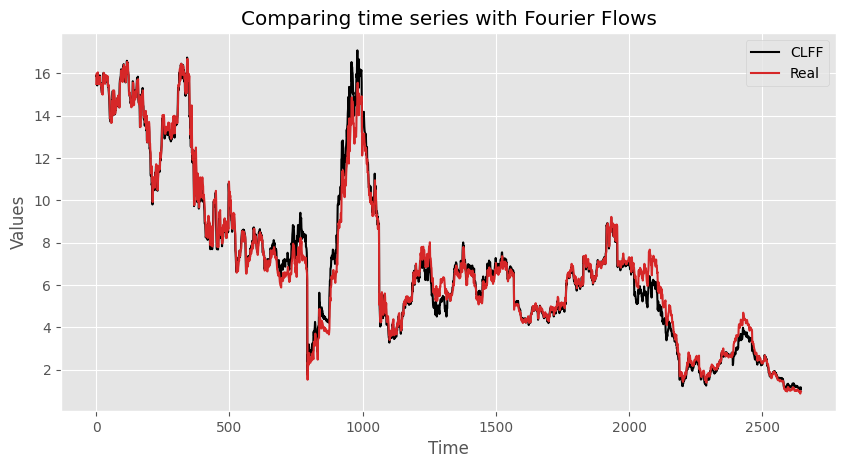

In [46]:
plt.subplots(figsize=(10,5), dpi=100)

plt.plot(result_CLFF[0], label='CLFF', color='black')
plt.plot(data.Close.values[:], label='Real', color='tab:red', alpha=1)

plt.title('Comparing time series with Fourier Flows')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()  

## Fourier flows without clustering

In [47]:
FF_model_wc = flows.f_fit(1, [data.Close.values], epochs=800, hidden=200, n_flows=10,\
                   display_step=100, lr=1e-4)

Start training Fourier Flows
step: 0 	/ 800 	--------	loss: 3207.320
step: 100 	/ 800 	|-------	loss: -14989.430
step: 200 	/ 800 	||------	loss: -21566.838
step: 300 	/ 800 	|||-----	loss: -23731.826
step: 400 	/ 800 	||||----	loss: -24750.875
step: 500 	/ 800 	|||||---	loss: -22786.449
step: 600 	/ 800 	||||||--	loss: -25289.986
step: 700 	/ 800 	|||||||-	loss: -26233.471
step: 799 	/ 800 	||||||||	loss: -23652.535
Finished training!


### Generate synthetics

In [48]:
result_FF = []

for i in range(num_synths):
    seed = seeds[i]
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    synth_FF = flows.synths_flows(FF_model_wc, 1, [data.Close.values[0]], n_samples=1)
    synth_FF0 = length_equalizer(synth_FF, [len(data.Close.values)])
    
    result_FF.append(synth_FF0[0])

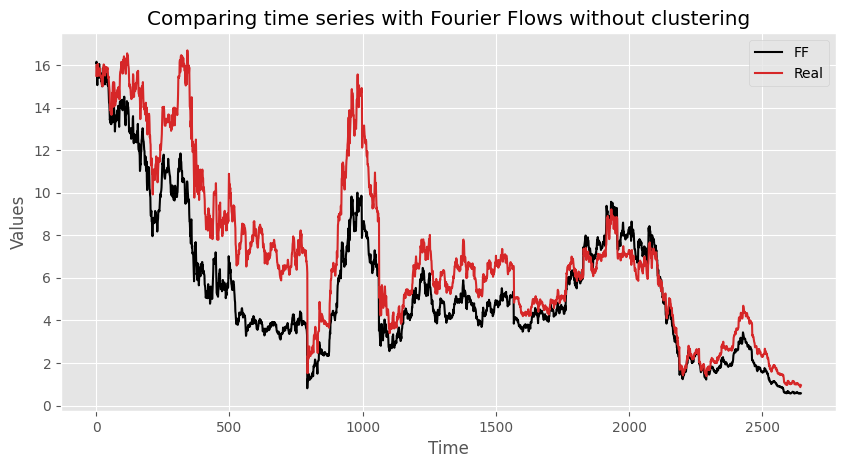

In [49]:
plt.subplots(figsize=(10,5), dpi=100)

plt.plot(result_FF[0], label='FF', color='black')
plt.plot(data.Close.values[:], label='Real', color='tab:red', alpha=1)

plt.title('Comparing time series with Fourier Flows without clustering')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.show() 

# Methods Comparison

## Visual estimation

In [50]:
# result_CLSGAN = pd.read_csv('CLSGAN_GEN')

In [51]:
# result_CLSGAN = result_CLSGAN.values

In [53]:
# res_df_CLSGAN = pd.DataFrame({'synth': result_CLSGAN.reshape(1,-1)[0], 'real': data.Close.values})

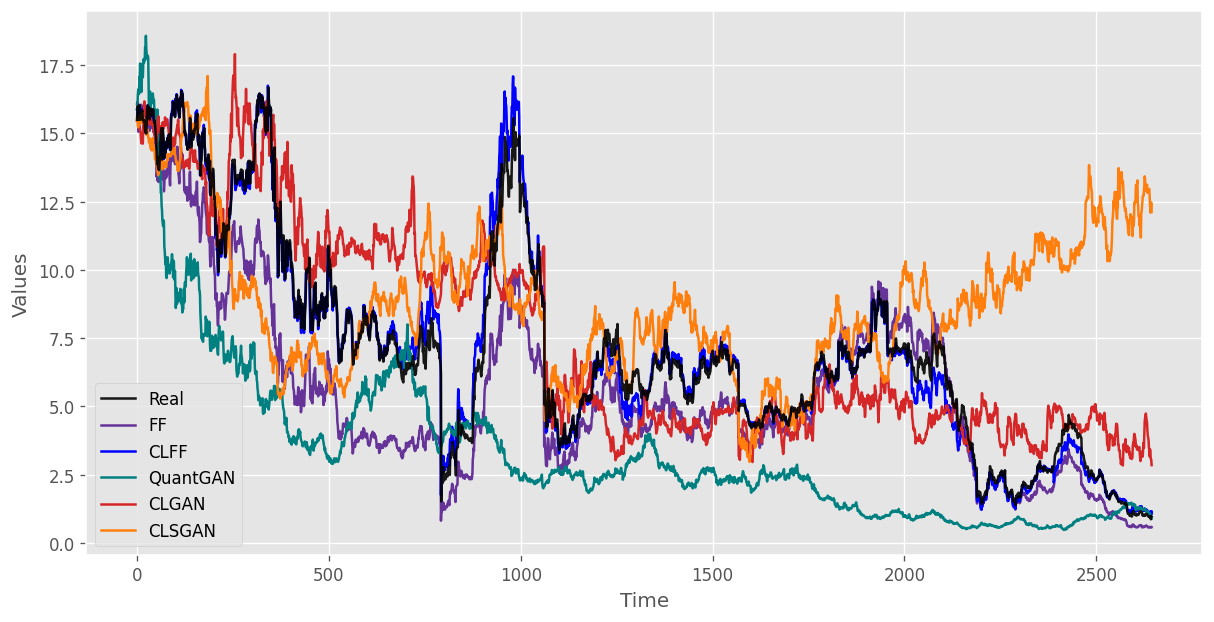

In [54]:
plt.subplots(figsize=(12,6), dpi=120)

plt.plot(data.Close.values, label='Real', color='black', alpha=0.9, zorder=3)
plt.plot(result_FF[0], label='FF', color='rebeccapurple')
plt.plot(result_CLFF[0], label='CLFF', color='blue')
plt.plot(result_QuantGAN[0], label='QuantGAN', color='teal') 
plt.plot(result_CLGAN[0], label='CLGAN', color='tab:red') 
plt.plot(result_CLSGAN[0], label='CLSGAN', color='tab:orange')



# plt.title('Comparing all synthetic time series')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.savefig(f'Visual_{name}.jpg', dpi=120) #save figure
plt.show()

## Distribution comparison

In [101]:
real = data.Close.values
res_df_CLFF = pd.DataFrame({'synth': result_CLFF[0], 'real': real})
res_df_QuantGAN = pd.DataFrame({'synth': result_QuantGAN[0], 'real': real})
res_df_CLGAN = pd.DataFrame({'synth': result_CLGAN[0], 'real': real})
res_df_FF = pd.DataFrame({'synth': result_FF[0], 'real': real})
res_df_CLSGAN = pd.DataFrame({'synth': result_CLSGAN[5], 'real': data.Close.values})

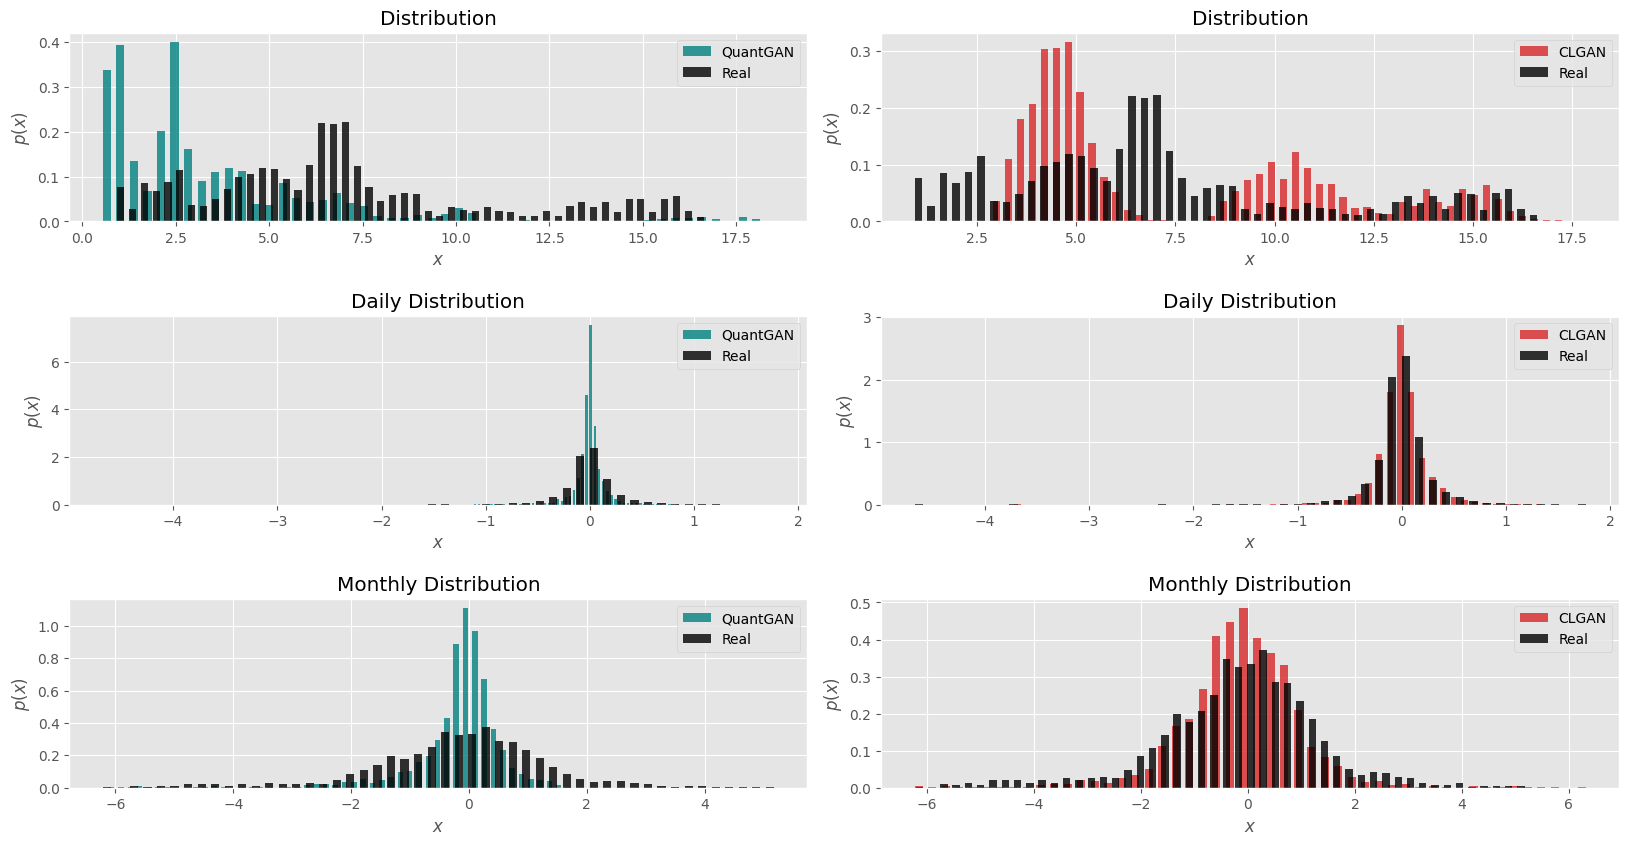

In [56]:
figure, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10), dpi=100)

titles = ('Distribution', 'Daily Distribution',\
          'Monthly Distribution')
differences = [(res_df_CLGAN['synth'], res_df_CLGAN['real']), (res_df_CLGAN['synth'].diff(), res_df_CLGAN['real'].diff()),\
               (res_df_CLGAN['synth'].diff(30), res_df_CLGAN['real'].diff(30))]

titles1 = ('Distribution', 'Daily Distribution', 'Monthly Distribution')
differences1 = [(res_df_QuantGAN['synth'], res_df_QuantGAN['real']), (res_df_QuantGAN['synth'].diff(),\
                res_df_QuantGAN['real'].diff()), (res_df_QuantGAN['synth'].diff(30), res_df_QuantGAN['real'].diff(30))]

xlimits = ((0, 35), (-3, 3), (-7.5, 7.5))

for i in range(3):
    
#     axs[i,0].hist([differences[i][0], differences[i][1]], bins=50, label=['synth', 'real'],\
#                   color=['black','tab:red'], density=True)
    axs[i,0].hist(differences1[i][0], bins=50, label='QuantGAN', color='teal', density=True, alpha=0.8, rwidth=0.6)
    axs[i,0].hist(differences1[i][1], bins=50, label='Real', color='black', density=True, alpha=0.8, rwidth=0.6)

    axs[i,0].legend(loc='upper right')
    axs[i,0].set_xlabel('$x$')
    axs[i,0].set_ylabel('$p(x)$')
    axs[i,0].set_title(f'{titles1[i]}')
#     axs[i,0].set_xlim(xlimits[i][0],xlimits[i][1])
    
#     axs[i,1].hist([differences1[i][0], differences1[i][1]], bins=50, label=['synth', 'real'],\
#                   color=['black','tab:red'], density=True)
    
    axs[i,1].hist(differences[i][0], bins=50, label='CLGAN', color='tab:red', density=True, alpha=0.8, rwidth=0.6)
    axs[i,1].hist(differences[i][1], bins=50, label='Real', color='black', density=True, alpha=0.8, rwidth=0.6)

    axs[i,1].legend(loc='upper right')
    axs[i,1].set_xlabel('$x$')
    axs[i,1].set_ylabel('$p(x)$')
    axs[i,1].set_title(f'{titles[i]}')
#     axs[i,1].set_xlim(xlimits[i][0],xlimits[i][1])

# figure.suptitle('Distribution Comparison TCN GAN', fontsize=18)
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.savefig(f'Distr_CLGAN_{name}.jpg', dpi=120) #save figure
plt.show()

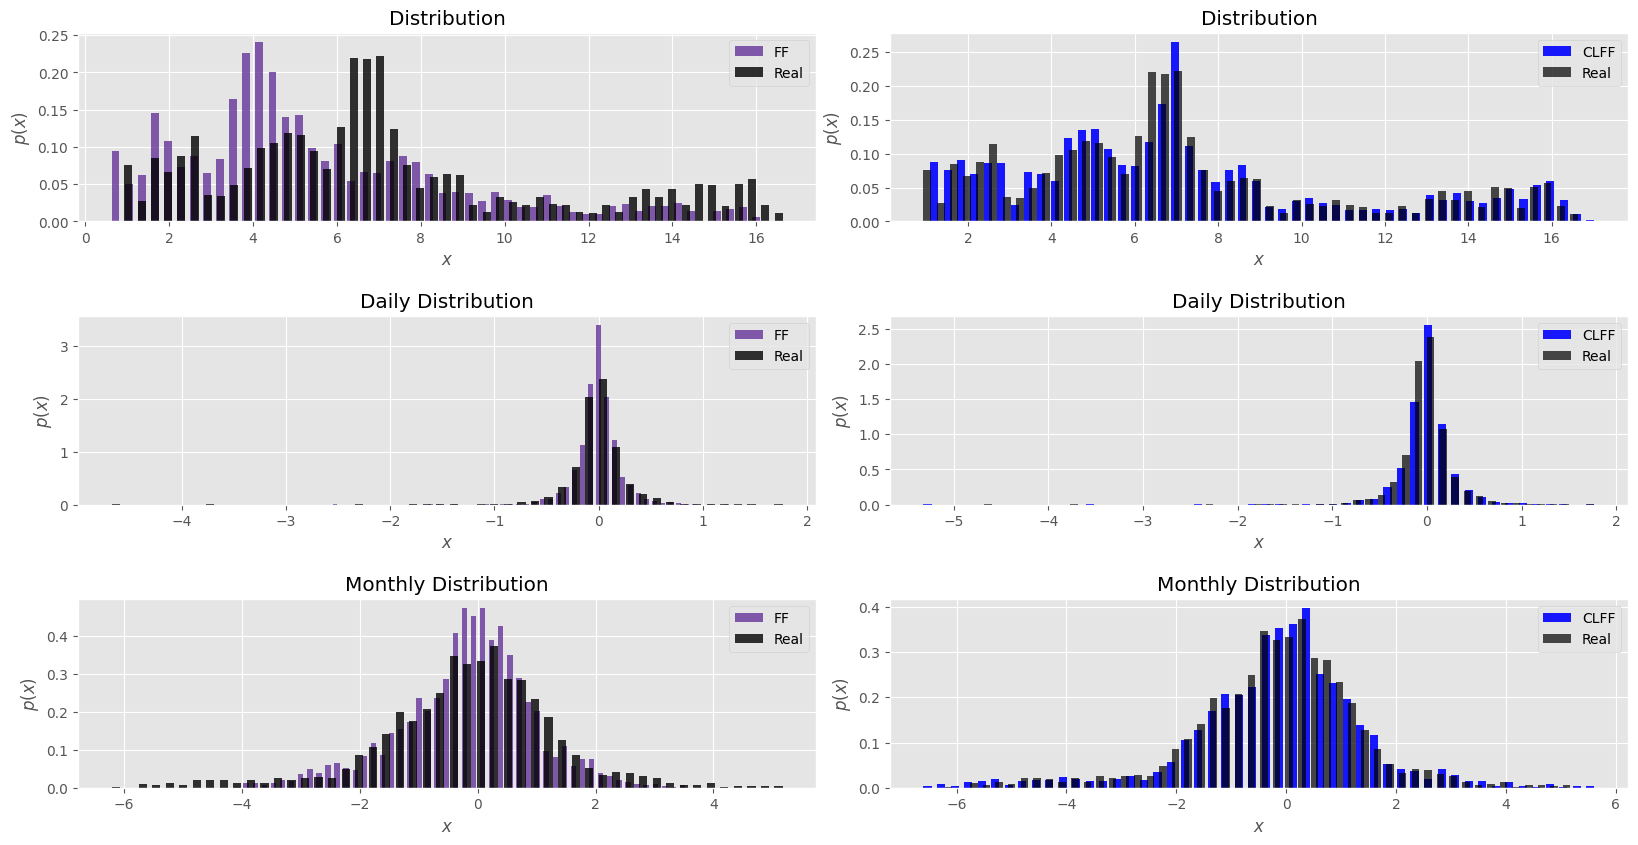

In [57]:
figure, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10), dpi=100)

titles = ('Distribution', 'Daily Distribution',\
          'Monthly Distribution')
differences = [(res_df_CLFF['synth'], res_df_CLFF['real']), (res_df_CLFF['synth'].diff(), res_df_CLFF['real'].diff()),\
               (res_df_CLFF['synth'].diff(30), res_df_CLFF['real'].diff(30))]

titles1 = ('Distribution', 'Daily Distribution', 'Monthly Distribution')
differences1 = [(res_df_FF['synth'], res_df_FF['real']), (res_df_FF['synth'].diff(),\
                res_df_FF['real'].diff()), (res_df_FF['synth'].diff(30), res_df_FF['real'].diff(30))]

xlimits = ((0, 35), (-3, 3), (-7.5, 7.5))

for i in range(3):
    
#     axs[i,0].hist([differences[i][0], differences[i][1]], bins=50, label=['synth', 'real'],\
#                   color=['black','tab:red'], density=True)
    axs[i,0].hist(differences1[i][0], bins=50, label='FF', color='rebeccapurple', density=True, alpha=0.8, rwidth=0.6)
    axs[i,0].hist(differences1[i][1], bins=50, label='Real', color='black', density=True, alpha=0.8, rwidth=0.6)

    axs[i,0].legend(loc='upper right')
    axs[i,0].set_xlabel('$x$')
    axs[i,0].set_ylabel('$p(x)$')
    axs[i,0].set_title(f'{titles1[i]}')
#     axs[i,0].set_xlim(xlimits[i][0],xlimits[i][1])
    
#     axs[i,1].hist([differences1[i][0], differences1[i][1]], bins=50, label=['synth', 'real'],\
#                   color=['black','tab:red'], density=True)
    
    axs[i,1].hist(differences[i][0], bins=50, label='CLFF', color='blue', density=True, alpha=0.9, rwidth=0.6)
    axs[i,1].hist(differences[i][1], bins=50, label='Real', color='black', density=True, alpha=0.7, rwidth=0.6)

    axs[i,1].legend(loc='upper right')
    axs[i,1].set_xlabel('$x$')
    axs[i,1].set_ylabel('$p(x)$')
    axs[i,1].set_title(f'{titles[i]}')
#     axs[i,1].set_xlim(xlimits[i][0],xlimits[i][1])

# figure.suptitle('Distribution Comparison Fourier Flows', fontsize=18)
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.savefig(f'Distr_FF_{name}.jpg', dpi=120) #save figure
plt.show()

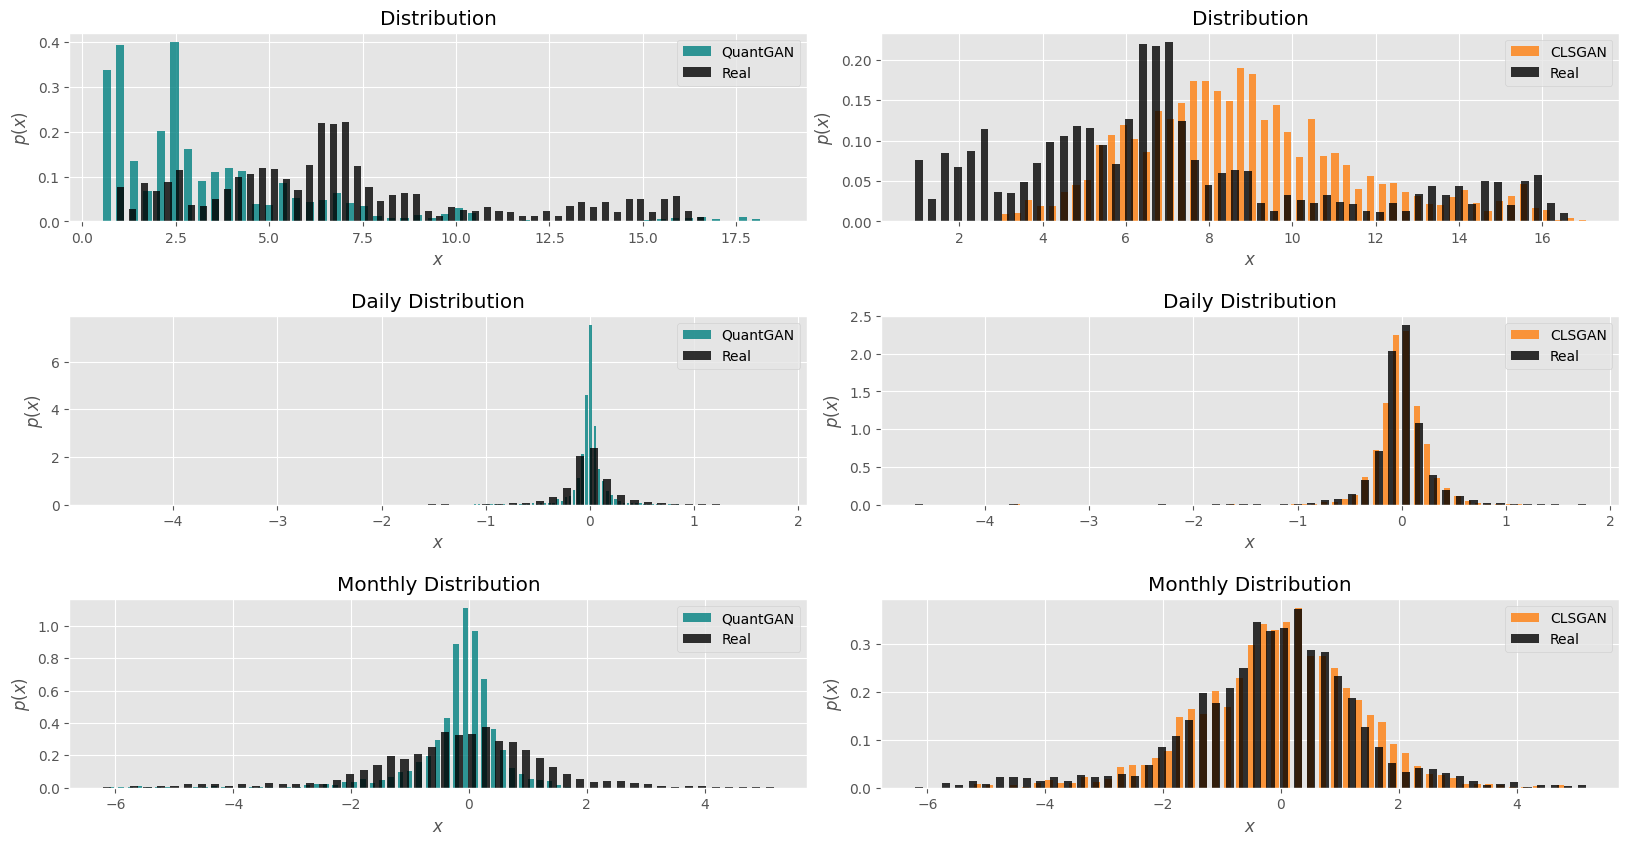

In [58]:
figure, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10), dpi=100)

titles = ('Distribution', 'Daily Distribution',\
          'Monthly Distribution')
differences = [(res_df_CLSGAN['synth'], res_df_CLSGAN['real']), (res_df_CLSGAN['synth'].diff(), res_df_CLSGAN['real'].diff()),\
               (res_df_CLSGAN['synth'].diff(30), res_df_CLSGAN['real'].diff(30))]

titles1 = ('Distribution', 'Daily Distribution', 'Monthly Distribution')
differences1 = [(res_df_QuantGAN['synth'], res_df_QuantGAN['real']), (res_df_QuantGAN['synth'].diff(),\
                res_df_QuantGAN['real'].diff()), (res_df_QuantGAN['synth'].diff(30), res_df_QuantGAN['real'].diff(30))]

xlimits = ((0, 35), (-3, 3), (-7.5, 7.5))

for i in range(3):
    
#     axs[i,0].hist([differences[i][0], differences[i][1]], bins=50, label=['synth', 'real'],\
#                   color=['black','tab:red'], density=True)
    axs[i,0].hist(differences1[i][0], bins=50, label='QuantGAN', color='teal', density=True, alpha=0.8, rwidth=0.6)
    axs[i,0].hist(differences1[i][1], bins=50, label='Real', color='black', density=True, alpha=0.8, rwidth=0.6)

    axs[i,0].legend(loc='upper right')
    axs[i,0].set_xlabel('$x$')
    axs[i,0].set_ylabel('$p(x)$')
    axs[i,0].set_title(f'{titles1[i]}')
#     axs[i,0].set_xlim(xlimits[i][0],xlimits[i][1])
    
#     axs[i,1].hist([differences1[i][0], differences1[i][1]], bins=50, label=['synth', 'real'],\
#                   color=['black','tab:red'], density=True)
    
    axs[i,1].hist(differences[i][0], bins=50, label='CLSGAN', color='tab:orange', density=True, alpha=0.8, rwidth=0.6)
    axs[i,1].hist(differences[i][1], bins=50, label='Real', color='black', density=True, alpha=0.8, rwidth=0.6)

    axs[i,1].legend(loc='upper right')
    axs[i,1].set_xlabel('$x$')
    axs[i,1].set_ylabel('$p(x)$')
    axs[i,1].set_title(f'{titles[i]}')
#     axs[i,1].set_xlim(xlimits[i][0],xlimits[i][1])

# figure.suptitle('Distribution Comparison TCN GAN', fontsize=18)
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.savefig(f'Distr_CLSGAN_{name}.jpg', dpi=120) #save figure
plt.show()

## Characteristics Comparison

In [58]:
# synth_CLFF = res_df_CLFF['synth'].values
# synth_FF = res_df_FF['synth'].values
# synth_GAN = res_df_GAN['synth'].values
# synth_GAN_wc = res_df_GAN_wc['synth'].values

In [59]:
# statistics = {'Mean': [pd.DataFrame(synth_FF).iloc[:,0].mean(), pd.DataFrame(synth_FF_wc).iloc[:,0].mean(),\
#                        pd.DataFrame(synth_GAN).iloc[:,0].mean(), pd.DataFrame(synth_GAN_wc).iloc[:,0].mean(),\
#                        pd.DataFrame(real).iloc[:,0].mean()],
              
#               'Std': [pd.DataFrame(synth_FF).iloc[:,0].std(), pd.DataFrame(synth_FF_wc).iloc[:,0].std(),
#                       pd.DataFrame(synth_GAN).iloc[:,0].std(), pd.DataFrame(synth_GAN_wc).iloc[:,0].std(),\
#                       pd.DataFrame(real).iloc[:,0].std()],
              
#               'Skew': [pd.DataFrame(synth_FF).iloc[:,0].skew(), pd.DataFrame(synth_FF_wc).iloc[:,0].skew(),\
#                        pd.DataFrame(synth_GAN).iloc[:,0].skew(), pd.DataFrame(synth_GAN_wc).iloc[:,0].skew(),\
#                        pd.DataFrame(real).iloc[:,0].skew()],
              
#              'Kurtosis': [pd.DataFrame(synth_FF).iloc[:,0].kurtosis(),pd.DataFrame(synth_FF_wc).iloc[:,0].kurtosis(),\
#                           pd.DataFrame(synth_GAN).iloc[:,0].kurtosis(), pd.DataFrame(synth_GAN_wc).iloc[:,0].kurtosis(),\
#                           pd.DataFrame(real).iloc[:,0].kurtosis()],
             
#              'JS-divergence': [jensenshannon(real, synth_FF), jensenshannon(real, synth_FF_wc),\
#                                jensenshannon(real, synth_GAN), jensenshannon(real, synth_GAN_wc),\
#                                jensenshannon(real, real)],
             
#              'Spectral Density': [spectral_density(synth_FF), spectral_density(synth_FF_wc), spectral_density(synth_GAN),\
#                     spectral_density(synth_GAN_wc), spectral_density(real)],
             
#              'KS-test': [ks_2samp(synth_FF, real)[0], ks_2samp(synth_FF_wc, real)[0],\
#                          ks_2samp(synth_GAN, real)[0], ks_2samp(synth_GAN_wc, real)[0],\
#                          ks_2samp(real, real)[0]]
#              }

In [60]:
# pd.DataFrame(statistics, index=['Synth CLFF', 'Synth FF', 'Synth CLGAN', 'Synth QuantGAN', 'Real'])

### Autocorrelation

In [259]:
autocorr_real = []
for i in range(len(autocorr(data.Close.values))):
    if i%50 == 0:
        autocorr_real.append(autocorr(data.Close.values)[i])

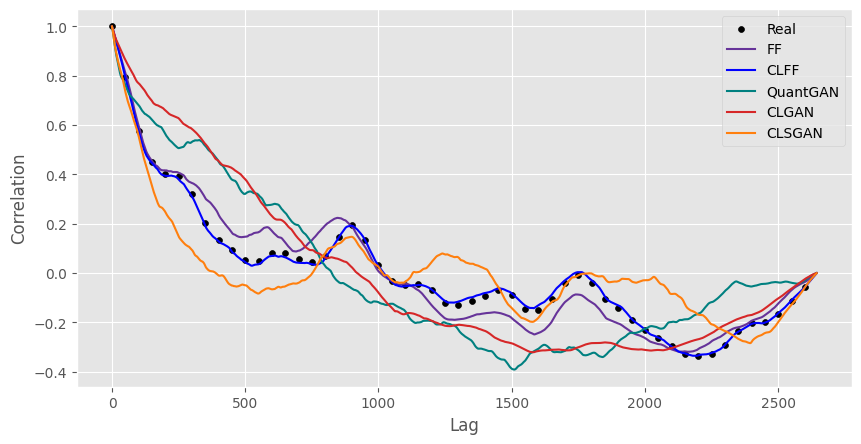

In [262]:
plt.subplots(figsize=(10,5), dpi=100)

plt.scatter(np.arange(0, len(data), step=50), autocorr_real, marker='o', s=18, label = 'Real', color='black')
plt.plot(autocorr(res_df_FF['synth']), label = 'FF', color='rebeccapurple')
plt.plot(autocorr(res_df_CLFF['synth']), label = 'CLFF', color='blue')
plt.plot(autocorr(res_df_QuantGAN['synth']), label = 'QuantGAN', color='teal')
plt.plot(autocorr(res_df_CLGAN['synth']), label = 'CLGAN', color='tab:red')
plt.plot(autocorr(res_df_CLSGAN['synth']), label = 'CLSGAN', color='tab:orange')


# plt.title('Autocorrelation', fontsize=16)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
# plt.savefig(f'Autocorr_{name}.png', dpi=300) #save figure
plt.show()

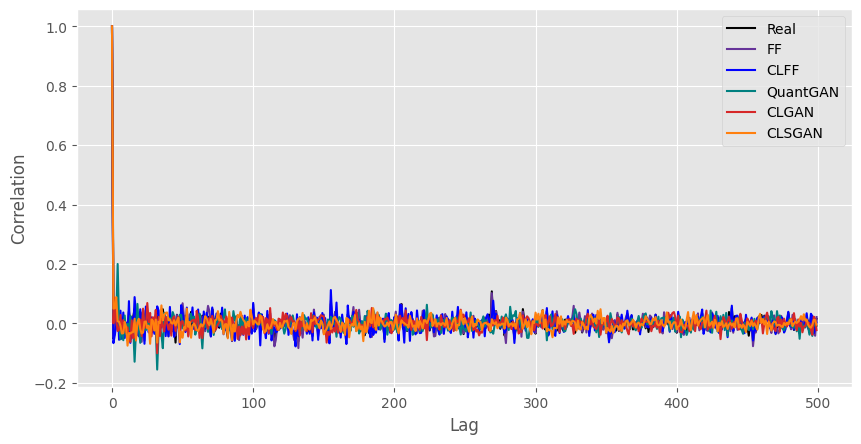

In [263]:
plt.subplots(figsize=(10,5), dpi=100)

plt.plot(autocorr(data.Close.diff()[1:])[:500], label = 'Real', color='black')
plt.plot(autocorr(res_df_FF['synth'].diff()[1:])[:500], label = 'FF', color='rebeccapurple')
plt.plot(autocorr(res_df_CLFF['synth'].diff()[1:])[:500], label = 'CLFF', color='blue')
plt.plot(autocorr(res_df_QuantGAN['synth'].diff()[1:])[:500], label = 'QuantGAN', color='teal')
plt.plot(autocorr(res_df_CLGAN['synth'].diff()[1:])[:500], label = 'CLGAN', color='tab:red')
plt.plot(autocorr(res_df_CLSGAN['synth'].diff()[1:])[:500], label = 'CLSGAN', color='tab:orange')


# plt.title('Autocorrelation', fontsize=16)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
# plt.savefig(f'Autocorr_{name}.jpg', dpi=120) #save figure
plt.show()

## Local extrema comparison

In [426]:
# def local_extr(q):
#     local_min_q = [q[0]]
#     local_max_q = [q[0]]
    
#     for i in range(1, len(q)-1):
#         if ((q[i] < q[i-1]) and (q[i] <= q[i+1])) or ((q[i] <= q[i-1]) and (q[i] < q[i + 1])):
#             local_min_q.append(q[i])
        
#         elif ((q[i] > q[i-1]) and (q[i] >= q[i + 1])) or ((q[i] >= q[i-1]) and (q[i] > q[i+1])):
#             local_max_q.append(q[i])
    
#     local_min_q.append(q[-1])
#     local_max_q.append(q[-1])
    
#     return local_min_q, local_max_q

In [62]:
def qunatile_comp(data):
#     local_extr_min, local_extr_max = local_extr(data)
    local_extr_min = data[argrelextrema(data, np.less_equal, order=50)[0]]
    local_extr_max = data[argrelextrema(data, np.greater_equal, order=50)[0]]
    
    local_sort_min = np.sort(local_extr_min)
    local_sort_max = np.sort(local_extr_max)
    
    quantiles_min = [local_sort_min.min()]
    quantiles_max = [local_sort_max.min()]

    for i in range(1, 100):
        quantiles_min.append(np.quantile(local_sort_min, i/100))
        quantiles_max.append(np.quantile(local_sort_max, i/100))

    quantiles_min.append(local_sort_min.max())
    quantiles_max.append(local_sort_max.max())
    
    return quantiles_min, quantiles_max

In [90]:
def qunatile_comp_join(data):
#     local_extr_min, local_extr_max = local_extr(data)
    local_extr_min = data[argrelextrema(data, np.less_equal, order=45)[0]]
    local_extr_max = data[argrelextrema(data, np.greater_equal, order=45)[0]]
    extr = np.concatenate([local_extr_min, local_extr_max])
    
    local_sort_extr = np.sort(extr)
#     local_sort_max = np.sort(local_extr_max)
    
    quantiles = [local_sort_extr.min()]
#     quantiles_max = [local_sort_max.min()]

    for i in range(1, 100):
        quantiles.append(np.quantile(local_sort_extr, i/100))
#         quantiles_max.append(np.quantile(local_sort_max, i/100))

    quantiles.append(local_sort_extr.max())
#     quantiles_max.append(local_sort_max.max())
    
    return quantiles

In [91]:
q_clsgan_min, q_clsgan_max = qunatile_comp(res_df_CLSGAN['synth'].values)
q_clgan_min, q_clgan_max = qunatile_comp(res_df_CLGAN['synth'].values)
q_clff_min, q_clff_max = qunatile_comp(res_df_CLFF['synth'].values)
q_ff_min, q_ff_max = qunatile_comp(res_df_FF['synth'].values)
q_quantgan_min, q_quantgan_max = qunatile_comp(res_df_QuantGAN['synth'].values)
q_real_min, q_real_max = qunatile_comp(data.Close.values)

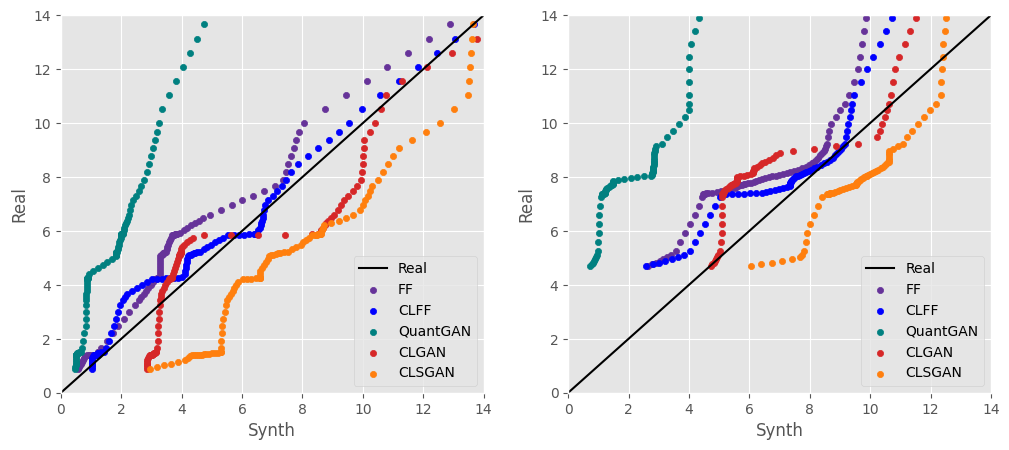

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=100)
lim_plot = int(max(list(map(max, [q_quantgan_min, q_clgan_min, q_clff_min, q_ff_min, q_clsgan_min, q_real_min]))))

# axs[0].plot(q_real_min, q_real_min, label='Real', color='black')
axs[0].plot(np.arange(lim_plot+1), label='Real', color='black')
axs[0].scatter(q_ff_min, q_real_min, s=20, label='FF', color='rebeccapurple')
axs[0].scatter(q_clff_min, q_real_min, s=20, label='CLFF', color='blue')
axs[0].scatter(q_quantgan_min, q_real_min, s=20, label='QuantGAN', color='teal')
axs[0].scatter(q_clgan_min, q_real_min, s=20, label='CLGAN', color='tab:red')
axs[0].scatter(q_clsgan_min, q_real_min, s=20, label='CLSGAN', color='tab:orange')


axs[0].set_xlabel('Synth')
axs[0].set_ylabel('Real')
axs[0].legend()
# axs[0].set_title('Local Minima')
axs[0].set_xlim(0, lim_plot)
axs[0].set_ylim(0, lim_plot)


# axs[1].plot(q_real_max, q_real_max, label='Real', color='black')
axs[1].plot(np.arange(lim_plot+1), label='Real', color='black')
axs[1].scatter(q_ff_max, q_real_max, s=20, label='FF', color='rebeccapurple')
axs[1].scatter(q_clff_max, q_real_max, s=20, label='CLFF', color='blue')
axs[1].scatter(q_quantgan_max, q_real_max, s=20, label='QuantGAN', color='teal')
axs[1].scatter(q_clgan_max, q_real_max, s=20, label='CLGAN', color='tab:red')
axs[1].scatter(q_clsgan_max, q_real_max, s=20, label='CLSGAN', color='tab:orange')


axs[1].set_xlabel('Synth')
axs[1].set_ylabel('Real')
axs[1].legend()
# axs[1].set_title('Local Maxima')
axs[1].set_xlim(0, lim_plot)
axs[1].set_ylim(0, lim_plot)

# plt.savefig(f'Local_Extr_{name}.png', dpi=300) #save figure
plt.show()

In [102]:
q_clsgan = qunatile_comp_join(res_df_CLSGAN['synth'].values)
q_clgan = qunatile_comp_join(res_df_CLGAN['synth'].values)
q_clff = qunatile_comp_join(res_df_CLFF['synth'].values)
q_ff = qunatile_comp_join(res_df_FF['synth'].values)
q_quantgan = qunatile_comp_join(res_df_QuantGAN['synth'].values)
q_real = qunatile_comp_join(data.Close.values)

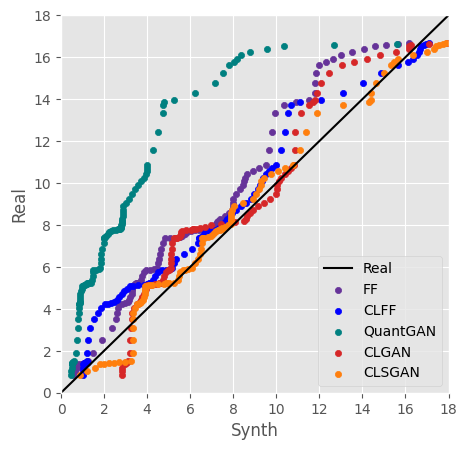

In [104]:
fig, axs = plt.subplots(figsize=(5,5), dpi=100)
lim_plot = int(max(list(map(max, [q_quantgan, q_clgan, q_clff, q_ff, q_clsgan, q_real]))))

# axs[0].plot(q_real_min, q_real_min, label='Real', color='black')
plt.plot(np.arange(lim_plot+1), label='Real', color='black')
plt.scatter(q_ff, q_real, s=20, label='FF', color='rebeccapurple')
plt.scatter(q_clff, q_real, s=20, label='CLFF', color='blue')
plt.scatter(q_quantgan, q_real, s=20, label='QuantGAN', color='teal')
plt.scatter(q_clgan, q_real, s=20, label='CLGAN', color='tab:red')
plt.scatter(q_clsgan, q_real, s=20, label='CLSGAN', color='tab:orange')
# plt.scatter(q_real, q_real, s=20, label='CLSGAN', color='black')

plt.xlabel('Synth')
plt.ylabel('Real')
plt.legend()
# axs[0].set_title('Local Minima')
plt.xlim(0, lim_plot)
plt.ylim(0, lim_plot)

plt.savefig(f'Local_Extr_{name}.png', dpi=300) #save figure
plt.show()

## ML Scores

### SpMSE

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [83]:
def split_by_idx(ts, idx):
#     idx_synth = copy.deepcopy(idx)
#     switch_regimes.insert(0, 0)
    array = []
    for i in range(len(idx) - 1):
        array.append(ts[idx[i]:idx[i+1]])
        
    return array  

In [84]:
def SPMSE(synth, real, alpha=1.01):
#     scaler = MinMaxScaler()
#     train_df = pd.DataFrame(np.concatenate([synth, real]))
#     train_df = pd.DataFrame(scaler.fit_transform(train_df))
    
#     train_df['Y'] = np.concatenate([np.zeros(len(synth)), np.ones(len(real))])
    train_df = pd.concat([pd.DataFrame(list(map(chi, split_by_idx(synth, idx_cp)))),\
           pd.DataFrame(list(map(chi, splitted)))])

    train_df['Y'] = np.concatenate([np.zeros(len(splitted)), np.ones(len(splitted))])
    train_df = shuffle(train_df)
    
    log_reg = LogisticRegression(solver='liblinear')
    log_reg.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])
    pred = log_reg.predict_proba(train_df.iloc[:,:-1])[:, 1]
    
    pMSE = 1/len(train_df) * sum((pred - 0.5)**2)
    EpMSE = ((9-1) * (1 - 0.5)**2 * 0.5) / len(train_df)
    return print(f'E_pMSE = {alpha**(-abs(1 - pMSE/EpMSE))}\np_MSE = {pMSE}')

In [85]:
SPMSE(res_df_CLGAN['synth'], data.Close.values, 1.01)

E_pMSE = 0.951936566978791
p_MSE = 0.13523353111294575


In [86]:
SPMSE(res_df_QuantGAN['synth'], data.Close.values, 1.01)

E_pMSE = 0.9567486508483882
p_MSE = 0.12371652503991502


In [87]:
SPMSE(res_df_CLFF['synth'], data.Close.values, 1.01)

E_pMSE = 0.9918242180909866
p_MSE = 0.003976441438921745


In [88]:
SPMSE(res_df_FF['synth'], data.Close.values, 1.01)

E_pMSE = 0.992634542677255
p_MSE = 0.005841776097986583


### MSE

In [351]:
# data = data.Close.values

In [63]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

# def forecasting_score(synth, real):
#     df = pd.DataFrame()
#     df['y'] = synth
#     df.index = pd.date_range(start='1/1/2022', periods=len(synth), freq='D')
#     df = df.reset_index()
#     df = df.rename(columns={'index': 'ds'})


#     m = Prophet(daily_seasonality=True, yearly_seasonality=20)
#     m.fit(df)
#     future = m.make_future_dataframe(periods=30)
    
#     pred_synth = m.predict(future)['yhat'][-30:]
    
#     df = pd.DataFrame()
#     df['y'] = real
#     df.index = pd.date_range(start='1/1/2022', periods=len(real), freq='D')
#     df = df.reset_index()
#     df = df.rename(columns={'index': 'ds'})


#     m = Prophet(daily_seasonality=True, yearly_seasonality=20)
#     m.fit(df)
#     future = m.make_future_dataframe(periods=30)
    
#     pred_real = m.predict(future)['yhat'][-30:]
    
#     return mean_squared_error(pred_synth, pred_real)

In [1]:
# forecasting_score(synth_GAN, data)

In [2]:
# forecasting_score(synth_GAN_wc, data)

In [3]:
# forecasting_score(synth_FF, data)

In [4]:
# forecasting_score(synth_FF_wc, data)

## Cross-validation by time series

In [64]:
n = 31
test_size = 60
train_size_init = int(len(data) - n*test_size)

def forecasting_cv(synth, real, train_size_init, test_size, n):
    array_mse = []
    train = synth[:train_size_init]
    train_size = train_size_init

    for i in range(n):
        df = pd.DataFrame()
        df['y'] = train
        df.index = pd.date_range(start='1/1/2022', periods=len(train), freq='D')
        df = df.reset_index()
        df = df.rename(columns={'index': 'ds'})

        m = Prophet(daily_seasonality=True)
        m.fit(df)
        
        future = m.make_future_dataframe(periods = test_size)
        pred_synth = m.predict(future)['yhat'][-test_size:]
        
        test_synth = synth[train_size : (train_size+test_size)]
        test_real = real[train_size : (train_size+test_size)]
        
        mse = mean_squared_error(pred_synth.values, test_real)
        
        train = np.concatenate([train, test_synth])
        
        train_size += test_size
        
        array_mse.append(mse)
        
    return array_mse

In [65]:
mse_res = np.array(forecasting_cv(res_df_CLGAN['synth'], data.Close.values, train_size_init, test_size, n))

In [66]:
mse_res_wc = np.array(forecasting_cv(res_df_QuantGAN['synth'], data.Close.values, train_size_init, test_size, n))

In [67]:
mse_real = np.array(forecasting_cv(data.Close.values, data.Close.values, train_size_init, test_size, n))

In [68]:
mse_CLFF = np.array(forecasting_cv(res_df_CLFF['synth'], data.Close.values, train_size_init, test_size, n))

In [69]:
mse_FF = np.array(forecasting_cv(res_df_FF['synth'], data.Close.values, train_size_init, test_size, n))

In [70]:
mse_CLSGAN = np.array(forecasting_cv(res_df_CLSGAN['synth'], data.Close.values, train_size_init, test_size, n))

In [71]:
pd.DataFrame([[mse_real.mean(), np.min(mse_real), np.max(mse_real)],
              [mse_FF.mean(), np.min(mse_FF), np.max(mse_FF)],
              [mse_CLFF.mean(), np.min(mse_CLFF), np.max(mse_CLFF)],
              [mse_res_wc.mean(), np.min(mse_res_wc), np.max(mse_res_wc)],
              [mse_res.mean(), np.min(mse_res), np.max(mse_res)],
              [mse_CLSGAN.mean(), np.min(mse_CLSGAN), np.max(mse_CLSGAN)]],\
             columns=['Mean', 'Min', 'Max'], index = ['Real', 'FF', 'CLFF', 'QuantGAN', 'CLGAN', 'CLSGAN'])


,Mean,Min,Max
Real,11.573453,0.205969,109.640533
FF,17.563865,0.087931,219.708036
CLFF,11.325787,0.195247,105.636909
QuantGAN,10.362041,0.278730,60.763429
CLGAN,8.564262,0.198493,31.339305
CLSGAN,12.151007,0.349425,39.847348


In [72]:
import seaborn as sns

In [73]:
df_mse = pd.DataFrame(np.array([mse_real, mse_FF, mse_CLFF, mse_res_wc, mse_res, mse_CLSGAN]).T,\
                      columns=['Real', 'FF', 'CLFF', 'QuantGAN', 'CLGAN', 'CLSGAN'])

In [74]:
df_new = df_mse['Real']
df_new = pd.DataFrame(pd.concat([df_new, df_mse['FF'], df_mse['CLFF'], df_mse['QuantGAN'], df_mse['CLGAN'], df_mse['CLSGAN']]), columns=['MSE'])
df_new['Models'] = np.concatenate([['Real']*len(df_mse['CLGAN']), ['FF']*len(df_mse['CLGAN']), ['CLFF']*len(df_mse['CLGAN']), ['QuantGAN']*len(df_mse['CLGAN']), ['CLGAN']*len(df_mse['CLGAN']), ['CLSGAN']*len(df_mse['CLGAN'])])
# df_new = df_mse['CLGAN']
# df_new = pd.DataFrame(pd.concat([df_new, df_mse['QuantGAN'], df_mse['Real']]), columns=['MSE'])
# df_new['Models'] = np.concatenate([['CLGAN']*len(df_mse['CLGAN']), ['QuantGAN']*len(df_mse['CLGAN']),['Real']*len(df_mse['CLGAN'])])

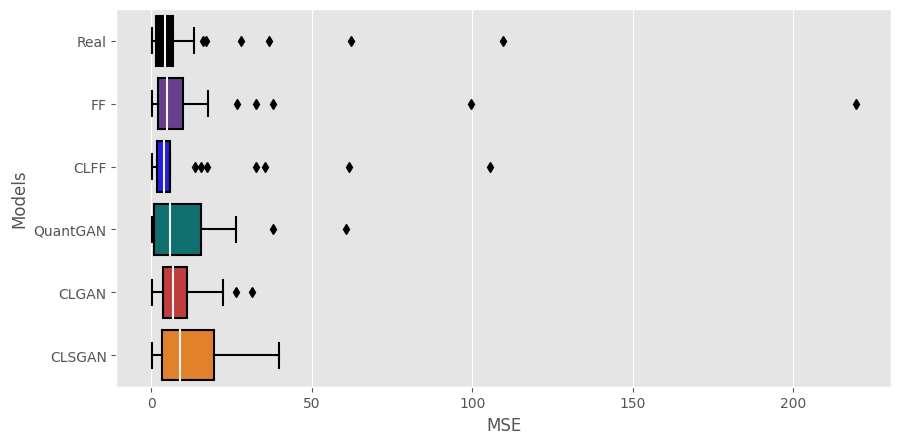

In [75]:
plt.subplots(figsize=(10,5), dpi=100)

my_pal = {'Real': "black", "FF": "rebeccapurple", "CLFF":"blue", 'QuantGAN': 'teal', 'CLGAN': 'tab:red', 'CLSGAN':'tab:orange'}

sns.boxplot(data=df_new, x='MSE', y='Models', palette=my_pal, medianprops={"color": "whitesmoke"})

plt.savefig(f'Boxplot_{name}.jpg', dpi=120) #save figure
plt.show()

## Statistical Significance Characteristics Comparison

In [296]:
real = data.Close.values

#QuantGAN
charact_quantgan_array = []
num_synths_quantgan = len(result_QuantGAN)

for i in range(num_synths_quantgan):
    df_quantgan = pd.DataFrame(result_QuantGAN[i]).iloc[:,0]
    charact_quantgan = [df_quantgan.mean(), df_quantgan.std(), df_quantgan.skew(), df_quantgan.kurtosis(),\
                       jensenshannon(real, result_QuantGAN[i]), spectral_density(result_QuantGAN[i]),\
                       ks_2samp(result_QuantGAN[i], real)[0]]
    
    charact_quantgan_array.append(charact_quantgan)
charact_quantgan_array = np.array(charact_quantgan_array)
    
    
#CLGAN    
charact_clgan_array = []
num_synths_clgan = len(result_CLGAN)

for i in range(num_synths_clgan):
    df_clgan = pd.DataFrame(result_CLGAN[i]).iloc[:,0]
    charact_clgan = [df_clgan.mean(), df_clgan.std(), df_clgan.skew(), df_clgan.kurtosis(),\
                       jensenshannon(real, result_CLGAN[i]), spectral_density(result_CLGAN[i]),\
                       ks_2samp(result_CLGAN[i], real)[0]]
    
    charact_clgan_array.append(charact_clgan)
charact_clgan_array = np.array(charact_clgan_array)

df_real = pd.DataFrame(real).iloc[:,0]
charact_real_array = np.array([df_real.mean(), df_real.std(), df_real.skew(), df_real.kurtosis(),\
                       jensenshannon(real, real), spectral_density(real),\
                       ks_2samp(real, real)[0]])


#FF
charact_FF_array = []
num_synths_FF = len(result_FF)

for i in range(num_synths_FF):
    df_FF = pd.DataFrame(result_FF[i]).iloc[:,0]
    charact_FF = [df_FF.mean(), df_FF.std(), df_FF.skew(), df_FF.kurtosis(),\
                       jensenshannon(real, result_FF[i]), spectral_density(result_FF[i]),\
                       ks_2samp(result_FF[i], real)[0]]
    
    charact_FF_array.append(charact_FF)
charact_FF_array = np.array(charact_FF_array)
    
    
#CLFF
charact_CLFF_array = []
num_synths_CLFF = len(result_CLFF)

for i in range(num_synths_CLFF):
    df_CLFF = pd.DataFrame(result_CLFF[i]).iloc[:,0]
    charact_CLFF = [df_CLFF.mean(), df_CLFF.std(), df_CLFF.skew(), df_CLFF.kurtosis(),\
                       jensenshannon(real, result_CLFF[i]), spectral_density(result_CLFF[i]),\
                       ks_2samp(result_CLFF[i], real)[0]]
    
    charact_CLFF_array.append(charact_CLFF)
charact_CLFF_array = np.array(charact_CLFF_array)


#CLSGAN
charact_clsgan_array = []
num_synths_clsgan = len(result_CLSGAN)

for i in range(num_synths_clsgan):
    df_clgan = pd.DataFrame(result_CLSGAN[i]).iloc[:,0]
    charact_clsgan = [df_clgan.mean(), df_clgan.std(), df_clgan.skew(), df_clgan.kurtosis(),\
                       jensenshannon(real, result_CLSGAN[i]), spectral_density(result_CLSGAN[i]),\
                       ks_2samp(result_CLSGAN[i], real)[0]]
    
    charact_clsgan_array.append(charact_clsgan)
charact_clsgan_array = np.array(charact_clsgan_array)


#Real
df_real = pd.DataFrame(real).iloc[:,0]
charact_real_array = np.array([df_real.mean(), df_real.std(), df_real.skew(), df_real.kurtosis(),\
                       jensenshannon(real, real), spectral_density(real),\
                       ks_2samp(real, real)[0]])

In [294]:
charact_CLFF_array = pd.DataFrame(charact_CLFF_array).replace([np.inf, -np.inf], np.nan).dropna().values
charact_FF_array = pd.DataFrame(charact_FF_array).replace([np.inf, -np.inf], np.nan).dropna().values
charact_quantgan_array = pd.DataFrame(charact_quantgan_array).replace([np.inf, -np.inf], np.nan).dropna().values
charact_clgan_array = pd.DataFrame(charact_clgan_array).replace([np.inf, -np.inf], np.nan).dropna().values
charact_clsgan_array = pd.DataFrame(charact_clsgan_array).replace([np.inf, -np.inf], np.nan).dropna().values

In [297]:
pd.DataFrame([charact_real_array, np.mean(charact_FF_array, axis=0), np.mean(charact_CLFF_array, axis=0),\
              np.mean(charact_quantgan_array, axis=0), np.mean(charact_clgan_array, axis=0),\
              np.mean(charact_clsgan_array, axis=0)], 
             columns=['Mean', 'Std', 'Skewness', 'Kurtosis', '$D_{JS}$', '$S_{\chi}$', 'KS'],\
             index=['Real', 'FF', 'CLFF', 'QuantGAN', 'CLGAN', 'CLSGAN'])

,Mean,Std,Skewness,Kurtosis,$D_{JS}$,$S_{\chi}$,KS
Real,7.083917,3.900073,0.746686,-0.135756,0.000000,2.004562,0.000000
FF,7.921802,4.030146,0.595252,-0.280062,0.077834,2.350343,0.159471
CLFF,7.091297,3.953745,0.733124,-0.152714,0.017935,2.393346,0.029055
QuantGAN,14.774445,1.446414,0.211438,-0.393357,0.188794,2.287293,0.843573
CLGAN,10.449899,3.243068,0.371483,-0.576829,0.162709,2.256937,0.455919
CLSGAN,10.907720,3.330803,0.336026,-0.552591,0.163686,1.995184,0.501647


In [236]:
clgan_skew = charact_clgan_array[:, 2]
clsgan_skew = charact_clsgan_array[:, 2]
clff_skew = charact_CLFF_array[:, 2]
ff_skew = charact_FF_array[:, 2]
quantgan_skew = charact_quantgan_array[:, 2]

In [206]:
from scipy.stats import t

In [251]:
def conf_interval_comp(data, alpha=0.05):
    m = data.mean() 
    s = data.std() 
    dof = len(data)-1 
    
    t_crit = (t.ppf((1-alpha/2), dof))
    
    return f'{m} +- {s*t_crit/np.sqrt(len(data))}'

In [264]:
conf_interval_comp(charact_clgan_array[:, 3], 0.05)

'-0.5768287998558527 +- 0.2892438225961521'

In [265]:
conf_interval_comp(charact_clsgan_array[:, 3], 0.05)

'-0.5525910230530414 +- 0.4117730403539774'

In [267]:
conf_interval_comp(charact_quantgan_array[:, 3], 0.05)

'-0.39335713803203204 +- 0.17859498859514664'

In [268]:
conf_interval_comp(charact_CLFF_array[:, 3], 0.05)

'-0.15271446630358695 +- 0.006502781831900897'

In [269]:
conf_interval_comp(charact_FF_array[:, 3], 0.05)

'-0.28006163169047793 +- 0.08291987518920783'

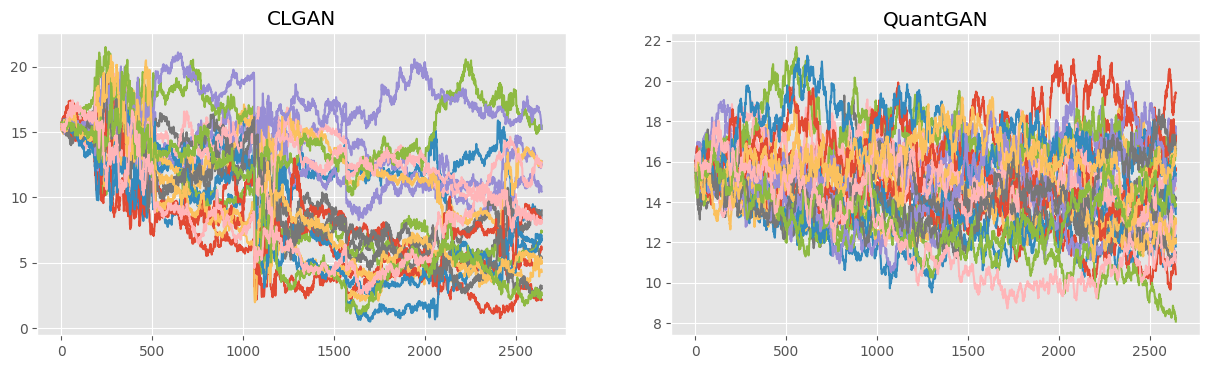

In [92]:
figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4), dpi=100)

for i in range(num_synths_clgan):
    axs[0].plot(result_CLGAN[i])
    
axs[0].set_title('CLGAN')
    
for i in range(num_synths_quantgan):
    axs[1].plot(result_QuantGAN[i])
    
axs[1].set_title('QuantGAN')
    
plt.show()